In [204]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix

import sys
sys.path.append('../code')
import chimerge

In [232]:
# 目标变量
target_var = 'Attrition'

# 连续变量
num_col = ['Age', 'MonthlyIncome', 'TotalWorkingYears','PercentSalaryHike',
           'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
           'YearsWithCurrManager', 'NumCompaniesWorked']
# 有序变量
ord_col = ['DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
           'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction',
           'StockOptionLevel', 'WorkLifeBalance', 'TrainingTimesLastYear']

# 分类变量
cat_col = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
           'MaritalStatus', 'OverTime']

In [233]:
train = pd.read_csv('../dataset/pfm_train.csv')
train.drop(['Over18', 'EmployeeNumber', 'StandardHours'], axis=1, inplace=True)
# test = pd.read_csv('../dataset/pfm_test.csv')

In [234]:
seed = 45
lr = LogisticRegression(random_state=seed)
kfold = StratifiedKFold(n_splits=10, random_state=seed)
cv_df = pd.DataFrame(np.zeros((12, 1)), index=range(1, 13), columns=['cv-score'])

In [208]:
# 分类变量创建虚拟变量
train = pd.get_dummies(train)

In [209]:
cat_col = [x for x in train.columns if x not in num_col+ord_col and x != target_var]

## 方案1 原始num_col+原始ord_col+cat_col-OneHot

In [210]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[0, 0] = cv_result.mean()
print('方案1：{:.4f}'.format(cv_result.mean()))

方案1：0.8799


## 方案2 原始num_col+ord_col-OneHot+cat_col-OneHot

In [211]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

for col in ord_col:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, dummies], axis=1)
    X.drop([col], axis=1, inplace=True)
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[1, 0] = cv_result.mean()
print('方案2：{:.4f}'.format(cv_result.mean()))

方案2：0.8864


## 方案3 原始num_col+ord_col-标准化+cat_col-OneHot

In [212]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

# 将ord_col视作连续变量，并进行标准化处理
std_scaler = StandardScaler()
for col in ord_col:
    X[col] = std_scaler.fit_transform(X[col].reshape(-1, 1))

cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[2, 0] = cv_result.mean()
print('方案3：{:.4f}'.format(cv_result.mean()))

方案3：0.8827


## 方案4 num_col标准化+原始ord_col+cat_col-OneHot

In [213]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

# 将num_col进行标准化处理
std_scaler = StandardScaler()
for col in num_col:
    X[col] = std_scaler.fit_transform(X[col].reshape(-1, 1))
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[3, 0] = cv_result.mean()
print('方案4：{:.4f}'.format(cv_result.mean()))

方案4：0.8818


## 方案5 num_col标准化+ord_col-OneHot+cat_col-OneHot

In [214]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

# 将num_col进行标准化处理
std_scaler = StandardScaler()
for col in num_col:
    X[col] = std_scaler.fit_transform(X[col].reshape(-1, 1))
    
for col in ord_col:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, dummies], axis=1)
    X.drop([col], axis=1, inplace=True)
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[4, 0] = cv_result.mean()
print('方案5：{:.4f}'.format(cv_result.mean()))

方案5：0.8772


## 方案6 num_col标准化+ord_col标准化+cat_col-OneHot

In [215]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

# 将num_col进行标准化处理
std_scaler = StandardScaler()
for col in num_col+ord_col:
    X[col] = std_scaler.fit_transform(X[col].reshape(-1, 1))
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[5, 0] = cv_result.mean()
print('方案6：{:.4f}'.format(cv_result.mean()))

方案6：0.8818


## 方案7 num_col开方+原始ord_col+cat_col-OneHot

In [216]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

X[num_col] = np.sqrt(X[num_col])
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[6, 0] = cv_result.mean()
print('方案7：{:.4f}'.format(cv_result.mean()))

方案7：0.8818


## 方案8 num_col开方+ord_col-OneHot+cat_col-OneHot

In [217]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

X[num_col] = np.sqrt(X[num_col])

for col in ord_col:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, dummies], axis=1)
    X.drop([col], axis=1, inplace=True)
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[7, 0] = cv_result.mean()
print('方案8：{:.4f}'.format(cv_result.mean()))

方案8：0.8791


## 方案9 num_col开方+ord_col标准化+cat_col-OneHot

In [218]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

X[num_col] = np.sqrt(X[num_col])

for col in ord_col:
    X[col] = std_scaler.fit_transform(X[col].reshape(-1, 1))
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[8, 0] = cv_result.mean()
print('方案9：{:.4f}'.format(cv_result.mean()))

方案9：0.8863


## 方案10 num_col开方标准化+原始ord_col+cat_col-OneHot

In [219]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

X[num_col] = np.sqrt(X[num_col])

for col in num_col:
    X[col] = std_scaler.fit_transform(X[col].reshape(-1, 1))
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[9, 0] = cv_result.mean()
print('方案10：{:.4f}'.format(cv_result.mean()))

方案10：0.8881


## 方案11 num_col开方标准化+ord_col-OneHot+cat_col-OneHot

In [220]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

X[num_col] = np.sqrt(X[num_col])

for col in num_col:
    X[col] = std_scaler.fit_transform(X[col].reshape(-1, 1))
    
for col in ord_col:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, dummies], axis=1)
    X.drop([col], axis=1, inplace=True)
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[10, 0] = cv_result.mean()
print('方案11：{:.4f}'.format(cv_result.mean()))

方案11：0.8773


## 方案12 num_col开方标准化+ord_col标准化+cat_col-OneHot

In [221]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

X[num_col] = np.sqrt(X[num_col])

for col in num_col+ord_col:
    X[col] = std_scaler.fit_transform(X[col].reshape(-1, 1))
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
cv_df.iloc[11, 0] = cv_result.mean()
print('方案12：{:.4f}'.format(cv_result.mean()))

方案12：0.8881


## 方案13 全部OneHot

In [222]:
X = train[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

for col in ord_col+num_col:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, dummies], axis=1)
    X.drop([col], axis=1, inplace=True)
    
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
#cv_df.iloc[10, 0] = cv_result.mean()
print('方案13：{:.4f}'.format(cv_result.mean()))

方案13：0.8654


## 连续变量四分位离散

In [223]:
X_qut = train[num_col+ord_col+cat_col].copy()
 
label_enc = LabelEncoder()
for col in num_col:
    X_qut[col] = pd.qcut(x=X_qut[col], q=4, duplicates='drop')
    X_qut[col] = label_enc.fit_transform(X_qut[col].reshape(-1,1)) + 1

## 方案14：连续变量离散+ord_col+cat_col-OneHot

In [182]:
X = X_qut[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
#cv_df.iloc[10, 0] = cv_result.mean()
print('方案14：{:.4f}'.format(cv_result.mean()))

方案14：0.8745


## 方案15：连续变量离散+ord_col-OneHot+cat_col-OneHot

In [183]:
X = X_qut[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

for col in ord_col:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, dummies], axis=1)
    X.drop([col], axis=1, inplace=True)

cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
#cv_df.iloc[10, 0] = cv_result.mean()
print('方案15：{:.4f}'.format(cv_result.mean()))

方案15：0.8754


## 方案16：连续变量离散OneHot+ord_col-OneHot+cat_col-OneHot

In [184]:
X = X_qut[num_col+ord_col+cat_col].copy()
y = train[target_var].copy()

for col in ord_col+num_col:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, dummies], axis=1)
    X.drop([col], axis=1, inplace=True)

cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
#cv_df.iloc[10, 0] = cv_result.mean()
print('方案16：{:.4f}'.format(cv_result.mean()))

方案16：0.8709


In [185]:
from sklearn.feature_selection import f_classif
score, pvalue = f_classif(X, y)
chi2_result = pd.DataFrame({'pvalue':pvalue}, index=X.columns)
# chi2_result.sort_values(by='pvalue', ascending=True)
cols = chi2_result[chi2_result['pvalue']<=0.05].index.tolist()

In [186]:
cv_result = cross_val_score(cv=kfold, estimator=lr, X=X[cols], y=y)
#cv_df.iloc[10, 0] = cv_result.mean()
print('方案16：{:.4f}'.format(cv_result.mean()))

方案16：0.8763


## 方案17 增加变量

In [187]:
def average_years(years_var):
    x, y, z = years_var
    if z == 0:
        return y
    else:
        return (x-y)/z
    
train['AverageWorkingYears'] = train[['TotalWorkingYears', 'YearsAtCompany', 'NumCompaniesWorked']].apply(average_years, axis=1)

In [193]:
X = train[num_col+ord_col+cat_col].copy()
X['AverageWorkingYears'] = train['AverageWorkingYears'].map(lambda x: 1 if x<=3 else 2)
label_enc = LabelEncoder()
for col in num_col:
    X[col] = pd.qcut(x=X[col], q=4, duplicates='drop')
    X[col] = label_enc.fit_transform(X[col].reshape(-1,1)) + 1

In [194]:
for col in ord_col+num_col+['AverageWorkingYears']:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, dummies], axis=1)
    X.drop([col], axis=1, inplace=True)

cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
#cv_df.iloc[10, 0] = cv_result.mean()
print('方案16：{:.4f}'.format(cv_result.mean()))

方案16：0.8754


## 方案18 连续变量离散化

In [202]:
# 连续变量
num_col = ['Age', 'MonthlyIncome', 'TotalWorkingYears','PercentSalaryHike',
           'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
           'YearsWithCurrManager', 'NumCompaniesWorked', 'AverageWorkingYears']
X = train[num_col+ord_col+cat_col+[target_var]].copy()

def meger(x, inver_list):
    for i in range(len(inver_list)):
        if x <= inver_list[i]:
            return i+1
    return i+2

for col in num_col:
    _, inver_list = chimerge.ChiMerge(df=X, variable=col, flag=target_var)
    X[col] = X[col].map(lambda x:meger(x, inver_list))

In [203]:
X.drop(['Attrition'], axis=1, inplace=True)
for col in ord_col+num_col:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, dummies], axis=1)
    X.drop([col], axis=1, inplace=True)

cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
#cv_df.iloc[10, 0] = cv_result.mean()
print('方案16：{:.4f}'.format(cv_result.mean()))

方案16：0.8927


## 方案19

In [310]:
X = train[num_col+cat_col+ord_col+[target_var]].copy()

for col in cat_col:
    X[col] = label_enc.fit_transform(X[col])
    
def meger(x, inver_list):
    for i in range(len(inver_list)):
        if x <= inver_list[i]:
            return i+1
    return i+2

for col in num_col:
    _, inver_list = chimerge.ChiMerge(df=X, variable=col, flag=target_var)
    X[col] = X[col].map(lambda x:meger(x, inver_list))
    
X.drop([target_var], axis=1, inplace=True)

In [247]:
rf = RandomForestClassifier(random_state=45, max_depth=3)
rf.fit(X, y)
rf.feature_importances_

array([ 0.07988531,  0.11551528,  0.02314174,  0.        ,  0.0749973 ,
        0.02081909,  0.        ,  0.08446211,  0.00523297,  0.        ,
        0.        ,  0.00257253,  0.        ,  0.056022  ,  0.05092627,
        0.17583483,  0.03986625,  0.        ,  0.03791333,  0.03554031,
        0.03925444,  0.02273705,  0.        ,  0.02485813,  0.0765529 ,
        0.03077947,  0.00308869])

In [248]:
gbdt = GradientBoostingClassifier(random_state=45, max_depth=3)
gbdt.fit(X, y)
gbdt.feature_importances_

array([ 0.08793322,  0.05851515,  0.02317913,  0.01379469,  0.04298344,
        0.01189517,  0.02701961,  0.01817086,  0.03266617,  0.0193635 ,
        0.03427011,  0.03033596,  0.00831179,  0.08656445,  0.02102302,
        0.05892177,  0.10029985,  0.0066925 ,  0.04944613,  0.0463799 ,
        0.02640057,  0.04901838,  0.        ,  0.02445467,  0.04691994,
        0.03597396,  0.03946606])

In [249]:
ada = AdaBoostClassifier(random_state=45)
ada.fit(X, y)
ada.feature_importances_

array([ 0.04,  0.14,  0.  ,  0.06,  0.04,  0.02,  0.06,  0.02,  0.04,
        0.04,  0.  ,  0.02,  0.02,  0.08,  0.02,  0.04,  0.04,  0.  ,
        0.04,  0.04,  0.02,  0.06,  0.  ,  0.02,  0.04,  0.06,  0.04])

In [251]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=45, max_depth=3)
et.fit(X, y)
et.feature_importances_

array([ 0.04334647,  0.03044775,  0.17195772,  0.        ,  0.11810627,
        0.02228985,  0.00087328,  0.03828046,  0.02355759,  0.00075808,
        0.00472112,  0.        ,  0.00120246,  0.        ,  0.06833742,
        0.20474675,  0.01893207,  0.00146775,  0.03986777,  0.00948139,
        0.02970138,  0.04519912,  0.00368984,  0.        ,  0.11617774,
        0.00516538,  0.00169232])

In [261]:
feature = pd.DataFrame({'rf':rf.feature_importances_, 'gbdt':gbdt.feature_importances_, 'ada':ada.feature_importances_, 'et':et.feature_importances_}, index=X.columns)

In [262]:
feature['mean'] = feature.mean(axis=1)

In [273]:
feature = feature.sort_values(by='mean', ascending=False)
feature

,ada,et,gbdt,rf,mean
OverTime,0.04,0.204747,0.058922,0.175835,0.119876
MonthlyIncome,0.14,0.030448,0.058515,0.115515,0.086120
StockOptionLevel,0.04,0.116178,0.046920,0.076553,0.069913
YearsAtCompany,0.04,0.118106,0.042983,0.074997,0.069022
Age,0.04,0.043346,0.087933,0.079885,0.062791
JobRole,0.08,0.000000,0.086564,0.056022,0.055647
TotalWorkingYears,0.00,0.171958,0.023179,0.023142,0.054570
DistanceFromHome,0.04,0.018932,0.100300,0.039866,0.049775
JobSatisfaction,0.06,0.045199,0.049018,0.022737,0.044239
EnvironmentSatisfaction,0.04,0.039868,0.049446,0.037913,0.041807


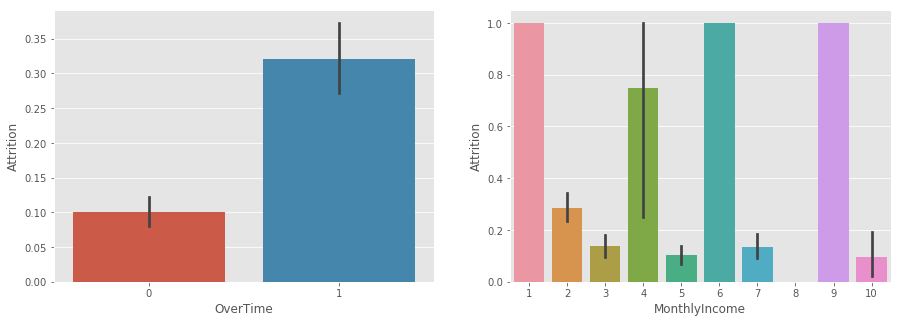

In [286]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(x='OverTime', y='Attrition', data=X)
plt.subplot(122)
sns.barplot(x='MonthlyIncome', y='Attrition', data=X)

在部分MonthlyIncome中，离职率为1。将Monthly和OverTime结合起来，分析去离职率影响

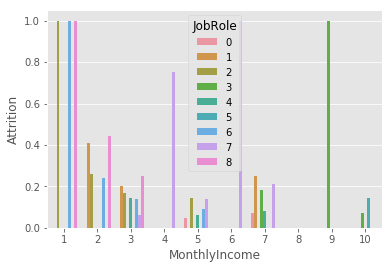

In [299]:
sns.barplot(x='MonthlyIncome', y='Attrition', data=X, hue='JobRole', errwidth=0)

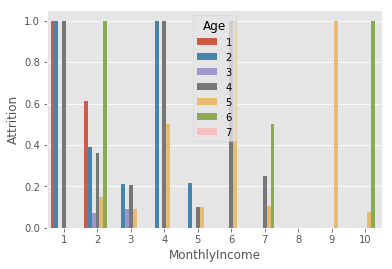

In [295]:
sns.barplot(x='MonthlyIncome', y='Attrition', data=X, hue='Age', errwidth=0)

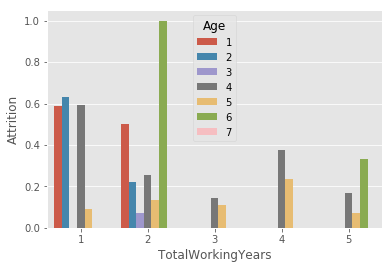

In [298]:
sns.barplot(x='TotalWorkingYears', y='Attrition', data=X, hue='Age', errwidth=0)

In [307]:
X['IncomeBank'] = X['MonthlyIncome'].map(lambda x: 1 if x in [1, 6, 9] else 0)

In [311]:
#X.drop(['MonthlyIncome'], axis=1, inplace=True)
X=X[select]
for col in select:
    dummies = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, dummies], axis=1)
    X.drop([col], axis=1, inplace=True)

cv_result = cross_val_score(cv=kfold, estimator=lr, X=X, y=y)
#cv_df.iloc[10, 0] = cv_result.mean()
print('方案16：{:.4f}'.format(cv_result.mean()))

方案16：0.8628


In [264]:
x = 0
for i in range(len(feature)):
    x += feature.iloc[i, 4]
    if x >= 0.5:
        print(i)
        break

6


In [267]:
select = feature.index.tolist()[:7]
cross_val_score(cv=kfold, estimator=rf, X=X[select], y=y).mean()

0.85182171328960321

In [241]:
X.head()

,Age,MonthlyIncome,TotalWorkingYears,PercentSalaryHike,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,NumCompaniesWorked,BusinessTravel,...,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,TrainingTimesLastYear
0,37,5993,7,18,7,5,0,7,1,2,...,4,1,2,2,3,3,3,1,4,2
1,54,10502,33,17,5,4,1,4,7,1,...,4,4,3,3,3,3,1,1,1,2
2,34,6074,9,24,9,7,0,6,1,1,...,3,1,1,2,3,4,4,0,3,3
3,39,12742,21,16,21,6,11,8,1,2,...,1,4,2,4,4,3,3,1,3,3
4,28,2596,1,15,1,0,0,0,1,1,...,3,1,2,1,2,3,1,2,3,2


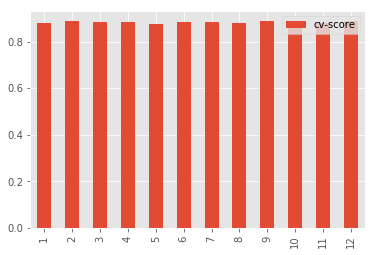

In [69]:
cv_df.plot(kind='bar')

## 连续变量等距离散化

## 构造新特征
1. 根据TotalWorkingYears，NumCompaniesWorked和YearsAtCompany，构造一个每个公司的平均工作年限。因为NumCompaniesWorked中有取值为0的值，因此这类员工就按YearsAtCompany赋值。

In [83]:
def average_years(years_var):
    x, y, z = years_var
    if z == 0:
        return y
    else:
        return (x-y)/z
    
train['AverageWorkingYears'] = train[['TotalWorkingYears', 'YearsAtCompany', 'NumCompaniesWorked']].apply(average_years, axis=1)
test['AverageWorkingYears'] = test[['TotalWorkingYears', 'YearsAtCompany', 'NumCompaniesWorked']].apply(average_years, axis=1)['AverageWorkingYears'] = test[['TotalWorkingYears', 'YearsAtCompany', 'NumCompaniesWorked']].apply(average_years, axis=1)

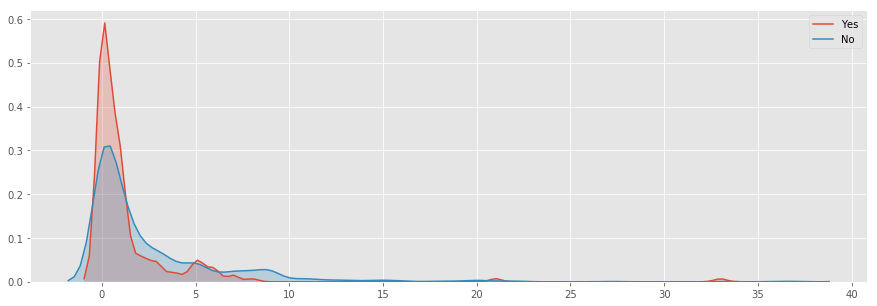

In [16]:
fig = plt.figure(figsize=(15,5))
sns.kdeplot(data=train.loc[train['Attrition']==1, 'AverageWorkingYears'], shade=True, label='Yes')
sns.kdeplot(data=train.loc[train['Attrition']==0, 'AverageWorkingYears'], shade=True, label='No')

In [17]:
def overtime_travel(overtravel):
    x, y = overtravel
    if x=='Travel_Rarely' and y == 1:
        return 1
    else:
        return 0

train['overtravel'] = train[['BusinessTravel', 'OverTime']].apply(overtime_travel, axis=1)

In [18]:
train.head(2)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AverageWorkingYears,overtravel
0,37,0,Travel_Rarely,Research & Development,1,4,Life Sciences,77,1,Male,...,1,7,2,4,7,5,0,7,0.0,0
1,54,0,Travel_Frequently,Research & Development,1,4,Life Sciences,1245,4,Female,...,1,33,2,1,5,4,1,4,4.0,0


In [19]:
train['AgeBank'] = pd.cut(x=train['Age'], bins=3, include_lowest=True)
train['WorkingBank'] = pd.cut(x=train['TotalWorkingYears'], bins=3)

In [20]:
def stock_bank(x):
    if x<3:
        return 1
    else:
        return 0
train['StockBank'] = train['StockOptionLevel'].map(lambda x:stock_bank(x))

In [21]:
def distance_bank(x):
    if x<3:
        return 1
    elif x<11:
        return 2
    else:
        return 3
train['DistanceBank'] = train['DistanceFromHome'].map(lambda x:distance_bank(x))

In [7]:
def chi2_merge(x, interval_list):
    for i in range(len(interval_list)):
        if x <= interval_list[i]:
            return i+1
    return i+2
    

#chi2_merge(60, [21, 26, 27, 33, 57, 58])
chi2_col = []
for col in num_col+ord_col:
    print(col+'...')
    _, interval_list = chimerge.ChiMerge(df=train, variable=col, flag=target_var)
    name = '{}_chi2'.format(col)
    chi2_col.append(name)
    train[name] = train[col].map(lambda x: chi2_merge(x, interval_list))
    test[name] = test[col].map(lambda x: chi2_merge(x, interval_list))

Age...
MonthlyIncome...
TotalWorkingYears...
PercentSalaryHike...
YearsAtCompany...
YearsInCurrentRole...
YearsSinceLastPromotion...
YearsWithCurrManager...
NumCompaniesWorked...
DistanceFromHome...
Education...


ValueError: min() arg is an empty sequence

In [98]:
onehot_col = []
for col in cat_col+chi2_col+ord_col:
    dummies = pd.get_dummies(train[col], prefix=col)
    
    train = pd.concat([train, dummies], axis=1)

    dummies = pd.get_dummies(test[col], prefix=col)
    onehot_col.extend(dummies.columns.tolist())
    test = pd.concat([test, dummies], axis=1)

In [317]:
train[num_col] = train[num_col].apply(lambda x: np.sqrt(x))

In [318]:
from sklearn.preprocessing import MinMaxScaler
standar_scaler = MinMaxScaler()
for col in num_col:
    train[col] = standar_scaler.fit_transform(train[col].values.reshape(-1,1))

In [319]:
train.head(2)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,TrainingTimesLastYear_5,TrainingTimesLastYear_6,DistanceBank_1,DistanceBank_2,DistanceBank_3,StockBank_0,StockBank_1,"AgeBank_(17.957, 32.0]","AgeBank_(32.0, 46.0]","AgeBank_(46.0, 60.0]"
0,37,0,Travel_Rarely,Research & Development,1,4,Life Sciences,77,1,Male,...,0,0,1,0,0,0,1,0,1,0
1,54,0,Travel_Frequently,Research & Development,1,4,Life Sciences,1245,4,Female,...,0,0,1,0,0,0,1,0,0,1


### 建立一个天真分类器

In [4]:
result = np.zeros((len(X_test)))
naive_score = sum(result==y_test)/len(X_test)
print('天真分类器 score={0:.4f}'.format(naive_score))

天真分类器 score=0.8424


In [80]:
rf = RandomForestClassifier(random_state=45)
score = cross_val_score(cv=kfold, estimator=rf, X=train[onehot_col], y=train[target_var])
print(score.mean())

0.850928852122


In [99]:
kfold = StratifiedKFold(n_splits=10, random_state=45)
lr = LogisticRegression(random_state=45, penalty='l1')
score = cross_val_score(cv=kfold, estimator=lr, X=train[onehot_col], y=train[target_var])
print(score.mean())

0.891831255776


In [106]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=lr, n_features_to_select=1)
rfe.fit(X=train[num_col+onehot_col], y=train[target_var])

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=45, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [107]:
backup_col = pd.DataFrame({'ranking':rfe.ranking_}, index=num_col+onehot_col).sort_values(by='ranking').index.tolist()

In [108]:
X_train, X_test, y_train, y_test = train_test_split(train[backup_col], train[target_var], test_size=0.3, random_state=45)

In [118]:
score_df = pd.DataFrame(np.zeros((len(backup_col), 2)), index=range(len(backup_col)), columns=['trainscore', 'testscore'])
for i in range(len(backup_col)):
    lr = LogisticRegression(random_state=45)
    cv_result = cross_validate(estimator=lr, X=train[backup_col[:i+1]], y=train[target_var], cv=kfold)
    #lr.fit(X_train[backup_col[:i+1]], y_train)
    #train_score = lr.score(X_train[backup_col[:i+1]], y_train)
    #test_score = lr.score(X_test[backup_col[:i+1]], y_test)
    score_df.iloc[i, 0] = cv_result['train_score'].mean()
    score_df.iloc[i, 1] = cv_result['test_score'].mean()
    #score = cross_val_score(cv=kfold, estimator=lr, X=train[backup_col[:i+1]], y=train[target_var])
    print('选择{:>3}个特征， train-score:{:.4f}, test-score:{:.4f}'.format(i+1, cv_result['train_score'].mean(), cv_result['test_score'].mean()))

选择  1个特征， train-score:0.8424, test-score:0.8409
选择  2个特征， train-score:0.8424, test-score:0.8409
选择  3个特征， train-score:0.8400, test-score:0.8400
选择  4个特征， train-score:0.8400, test-score:0.8400
选择  5个特征， train-score:0.8403, test-score:0.8400
选择  6个特征， train-score:0.8421, test-score:0.8400
选择  7个特征， train-score:0.8473, test-score:0.8454
选择  8个特征， train-score:0.8591, test-score:0.8591
选择  9个特征， train-score:0.8600, test-score:0.8600
选择 10个特征， train-score:0.8625, test-score:0.8618
选择 11个特征， train-score:0.8643, test-score:0.8618
选择 12个特征， train-score:0.8638, test-score:0.8627
选择 13个特征， train-score:0.8700, test-score:0.8672
选择 14个特征， train-score:0.8727, test-score:0.8682
选择 15个特征， train-score:0.8744, test-score:0.8700
选择 16个特征， train-score:0.8769, test-score:0.8718
选择 17个特征， train-score:0.8769, test-score:0.8763
选择 18个特征， train-score:0.8764, test-score:0.8691
选择 19个特征， train-score:0.8835, test-score:0.8791
选择 20个特征， train-score:0.8846, test-score:0.8836
选择 21个特征， train-score:0.8835, test-score

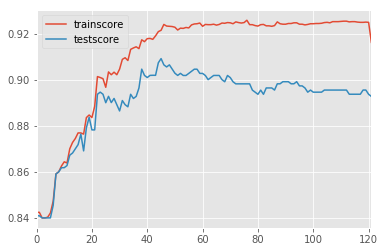

In [119]:
score_df.plot()

In [120]:
lr.fit(X=train[backup_col[:23]], y=train[target_var])
y_pred = lr.predict(train[backup_col[:23]])
confusion_matrix(y_pred=y_pred, y_true=train[target_var])

array([[909,  13],
       [ 94,  84]], dtype=int64)

In [121]:
result = lr.predict(test[backup_col[:23]])
submit = pd.DataFrame({'result':result.astype(int)})
submit.to_csv('result.csv', index=False)

In [109]:
score = cross_val_score(cv=kfold, estimator=rf, X=train[selected_col], y=train[target_var])
print(score.mean())

0.845482646951


In [101]:
new_col = pd.DataFrame({'score':rf.feature_importances_}, index=num_col+onehot_col)
selected_col = new_col.sort_values(by='score', ascending=False).index.tolist()[:10]

In [56]:
lr = LogisticRegression(random_state=45, class_weight='balanced', C=0.1)
lr.fit(X_train, y_train)
reslt = lr.predict_proba(X_test)
lr.score(X_test, y_test)

0.75454545454545452

In [57]:
from sklearn.metrics import accuracy_score

In [58]:
for threshold in np.linspace(0.8, 0.9, 10):
    pred = np.where(reslt[:, 1]>threshold, 1, 0)
    score = accuracy_score(y_true=y_test, y_pred=pred)
    print('阈值: {}, 得分:{}'.format(threshold, score))

阈值: 0.8, 得分:0.8727272727272727
阈值: 0.8111111111111111, 得分:0.8666666666666667
阈值: 0.8222222222222223, 得分:0.8727272727272727
阈值: 0.8333333333333334, 得分:0.8666666666666667
阈值: 0.8444444444444444, 得分:0.8696969696969697
阈值: 0.8555555555555556, 得分:0.8666666666666667
阈值: 0.8666666666666667, 得分:0.8696969696969697
阈值: 0.8777777777777778, 得分:0.8666666666666667
阈值: 0.888888888888889, 得分:0.8575757575757575
阈值: 0.9, 得分:0.8484848484848485


In [41]:
result = lr.predict_proba(df_test)
pred = np.where(result[:, 1]>0.8, 1, 0)
submit = pd.DataFrame({'result': pred.astype(int)})
submit.to_csv('result.csv', index=False)

### 原始模型预测

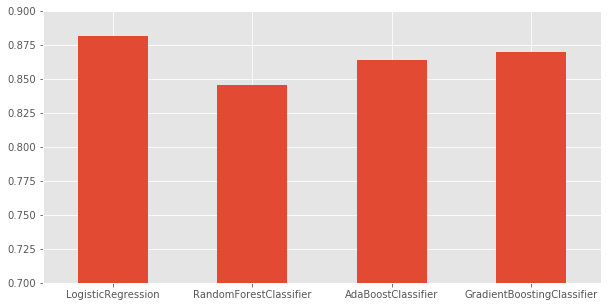

In [97]:
model = []

lr = LogisticRegression(random_state=45)
model.append(('LogisticRegression', lr))
rf = RandomForestClassifier(random_state=45)
model.append(('RandomForestClassifier', rf))
adaboost = AdaBoostClassifier(random_state=45)
model.append(('AdaBoostClassifier', adaboost))
gbdt = GradientBoostingClassifier(random_state=45)
model.append(('GradientBoostingClassifier', gbdt))

result_df = pd.DataFrame(np.zeros((4,4)), columns=['model', 'CV', 'test', 'time'])

for i, (name, clf) in enumerate(model):
    start = time.time()
    cv = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=kfold)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    result_df.iloc[i, 0] = name
    result_df.iloc[i, 1] = '{0:.4f}(+/-{0:.4f})'.format(cv.mean(), cv.std())
    result_df.iloc[i, 2] = '{0:.4f}'.format(score)
    result_df.iloc[i, 3] = '{0:.4f}'.format(time.time() - start)
    
result_df['test'] = result_df['test'].astype(float)
plt.figure(figsize=(10,5))
result_df['test'].plot(kind='bar')
_ = plt.xticks(range(len(model)),result_df['model'].values.tolist(), rotation=0)
_ = plt.xlim((-0.5, 3.5))
_ = plt.ylim((0.7, 0.9))

## 网格搜索最佳参数

In [77]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.05, 1., 20),verbose=0):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，
         其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                            n_jobs=n_jobs, train_sizes=train_sizes,
                                                            random_state=45, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,7))

    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1])\
              + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1])\
         - (test_scores_mean[-1] - test_scores_std[-1])

    return

In [100]:
def gridsearch(model, parameters, cv, X_train, y_train, X_test, y_test):
    grid_obj = GridSearchCV(estimator=model, param_grid=parameters, cv=cv).fit(X_train, y_train)

    print('交叉验证报告')
    print('=======================')
    print('最佳得分： {0:.4f}'.format(grid_obj.best_score_))
    print('最佳分类器参数为: {}'.format(grid_obj.best_params_))
    
    model.fit(X_train, y_train)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    
    print('训练集得分: {0:.4f}'.format(score_train))
    print('测试集得分: {0:.4f}'.format(score_test))

    plot_learning_curve(grid_obj.best_estimator_, X_train, y_train, ylim=None, cv=10, n_jobs=1,
                        train_sizes=np.linspace(.05, 1., 20),verbose=0)
    
    return grid_obj.best_estimator_, grid_obj.best_params_

交叉验证报告
最佳得分： 0.8766
最佳分类器参数为: {'C': 1.0, 'penalty': 'l1', 'tol': 0.0001}
训练集得分: 0.8974
测试集得分: 0.8818


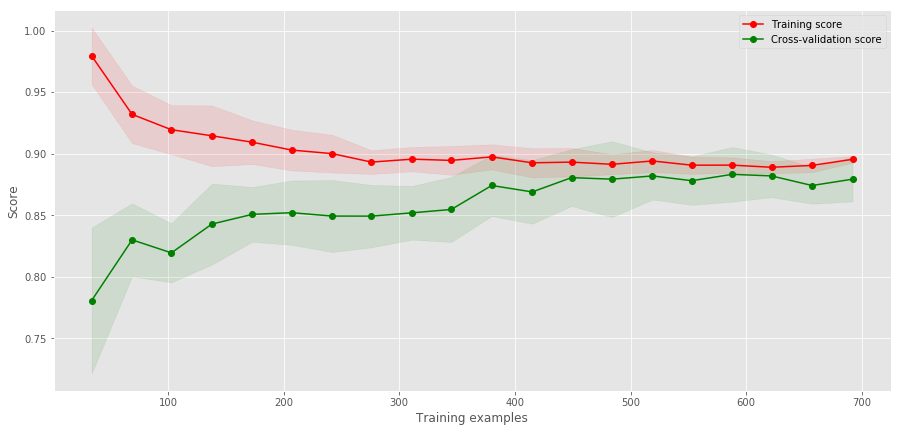

In [101]:
parameters = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 1, 5),
    'tol': np.logspace(-6, -1, 6),
}

lr, _ = gridsearch(lr, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8792
最佳分类器参数为: {'C': 1.2000000000000002, 'penalty': 'l1', 'tol': 0.0050000000000000001}
训练集得分: 0.8922
测试集得分: 0.8909


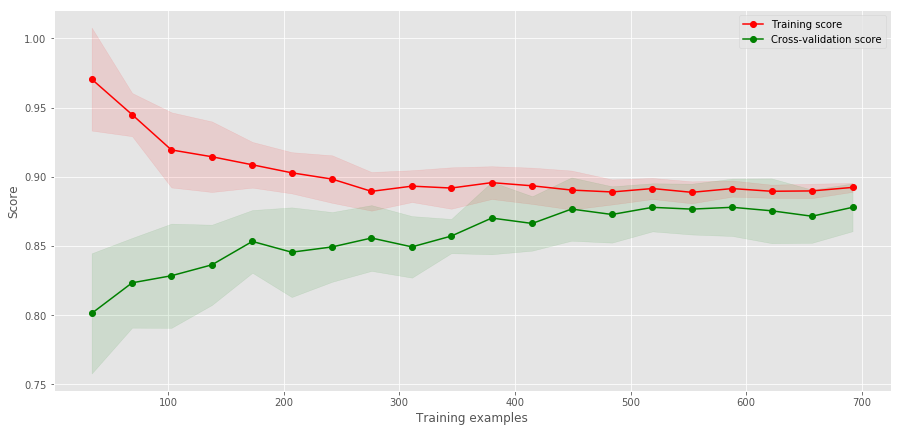

In [106]:
parameters = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(1.1, 1.5, 5),
    'tol': np.linspace(0.001, 0.01, 10),
}

lr, _ = gridsearch(lr, parameters, kfold, X_train, y_train, X_test, y_test)

#### 随机森林的调参

In [110]:
rf = RandomForestClassifier(max_features=10, min_impurity_split=100,
                            min_samples_leaf=20, random_state=45, oob_score=False)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'n_estimators': 10}
训练集得分: 0.8364
测试集得分: 0.8424


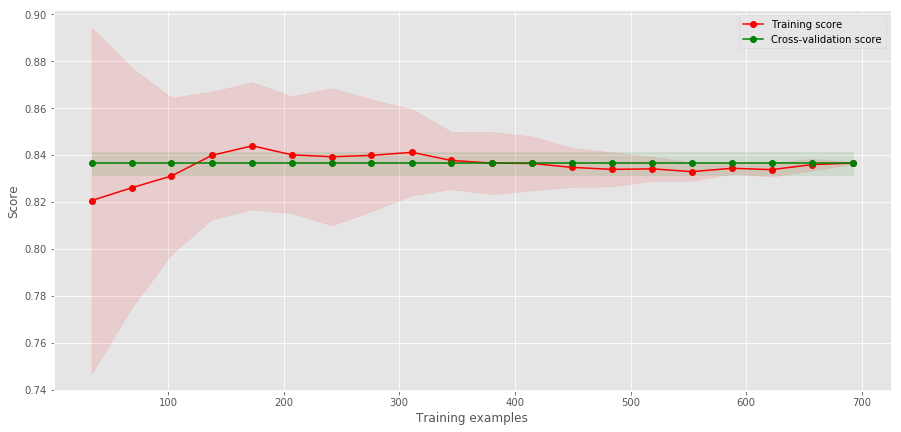

In [111]:
# 首先确定需要多少颗树
parameters = {
    'n_estimators': range(10, 110, 10)
}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'n_estimators': 1}
训练集得分: 0.8364
测试集得分: 0.8424


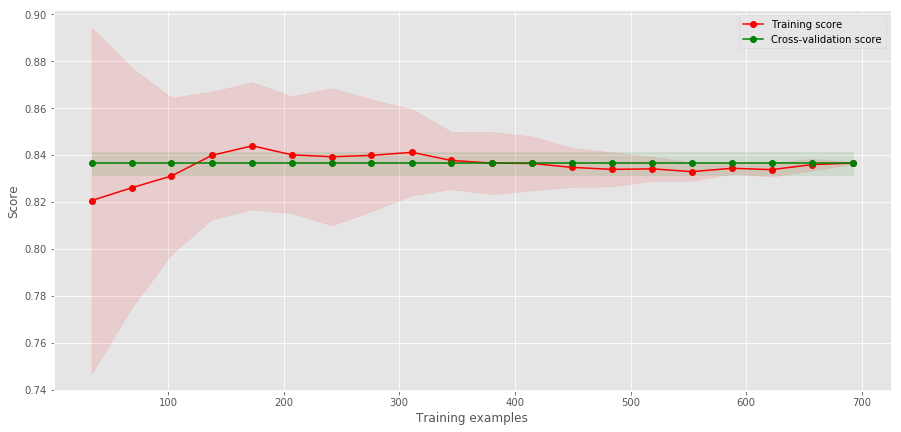

In [112]:
# 首先确定需要多少颗树
parameters = {
    'n_estimators': range(1, 11)
}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'max_depth': 3, 'min_samples_split': 50}
训练集得分: 0.8364
测试集得分: 0.8424


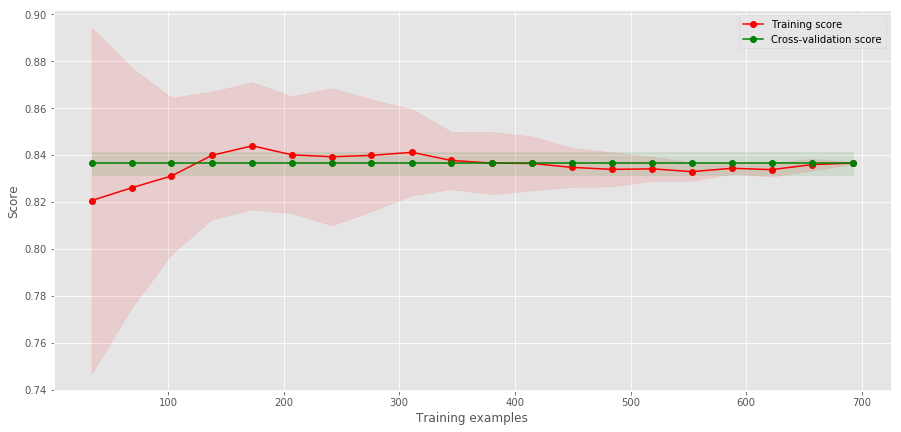

In [114]:
# 确定最大深度max_depth和min_samples_split
parameters = {'max_depth':range(3,14,2), 'min_samples_split':range(50,201,20)}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'max_depth': 1, 'min_samples_split': 10}
训练集得分: 0.8364
测试集得分: 0.8424


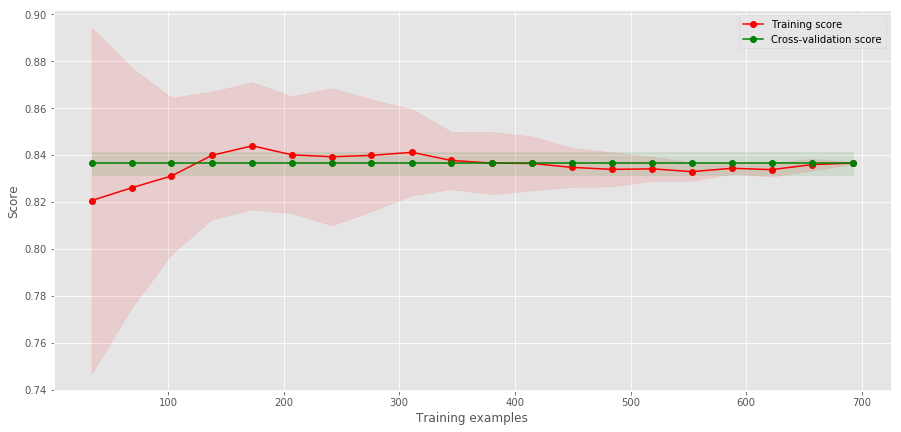

In [117]:
# 确定最大深度max_depth和min_samples_split
parameters = {'max_depth':[1, 2, 3, 4], 'min_samples_split':range(10, 41, 10)}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'min_samples_split': 20}
训练集得分: 0.8364
测试集得分: 0.8424


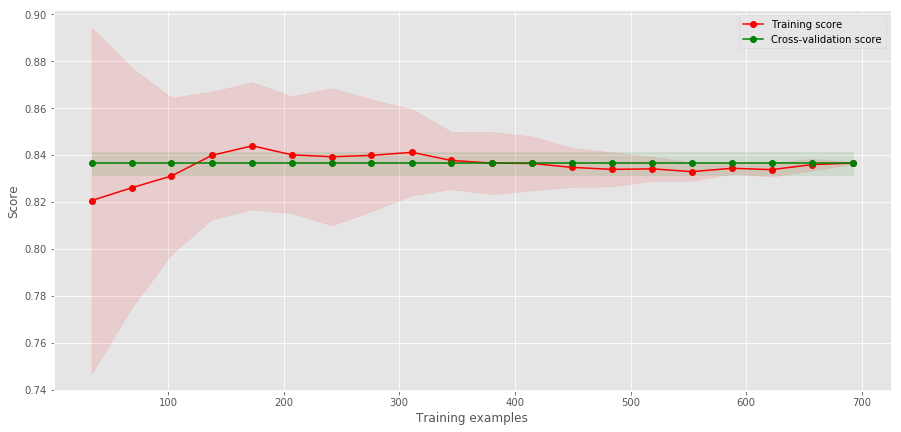

In [119]:
# 确定最大深度max_depth和min_samples_split
parameters = {'min_samples_split':[20, 30, 40]}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'min_samples_split': 10}
训练集得分: 0.8364
测试集得分: 0.8424


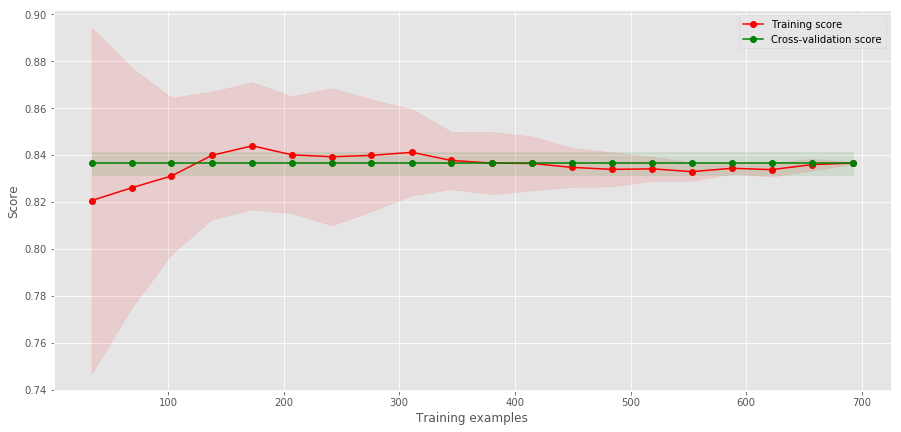

In [120]:
# 确定最大深度max_depth和min_samples_split
parameters = {'min_samples_split':[10, 20]}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'min_samples_split': 10}
训练集得分: 0.8364
测试集得分: 0.8424


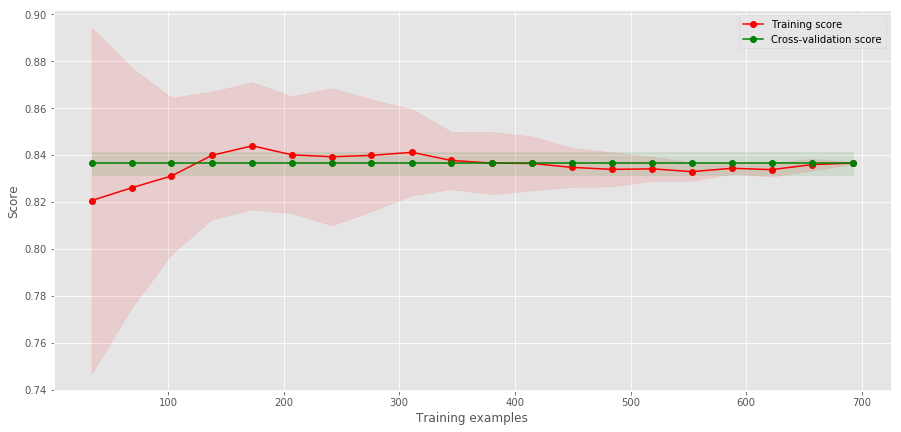

In [121]:
# 确定最大深度max_depth和min_samples_split
parameters = {'min_samples_split':[10, 5, 15]}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'min_samples_leaf': 10, 'min_samples_split': 80}
训练集得分: 0.8364
测试集得分: 0.8424


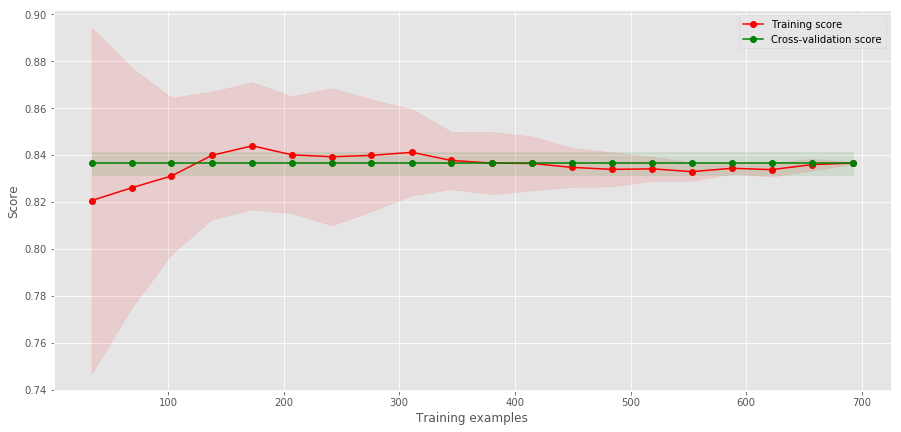

In [123]:
parameters = {'min_samples_split':range(80,150,20), 'min_samples_leaf':range(10,60,10)}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'min_samples_leaf': 10, 'min_samples_split': 60}
训练集得分: 0.8364
测试集得分: 0.8424


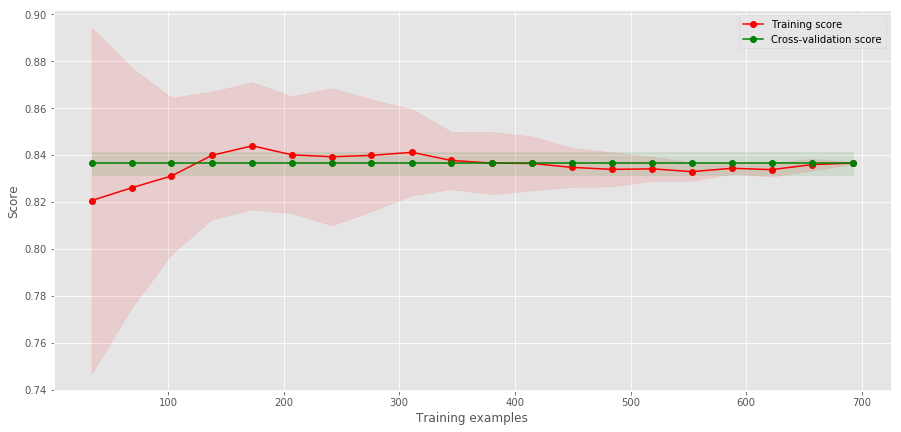

In [124]:
parameters = {'min_samples_split':[60, 70, 80], 'min_samples_leaf':range(10,60,10)}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'min_samples_leaf': 10, 'min_samples_split': 40}
训练集得分: 0.8364
测试集得分: 0.8424


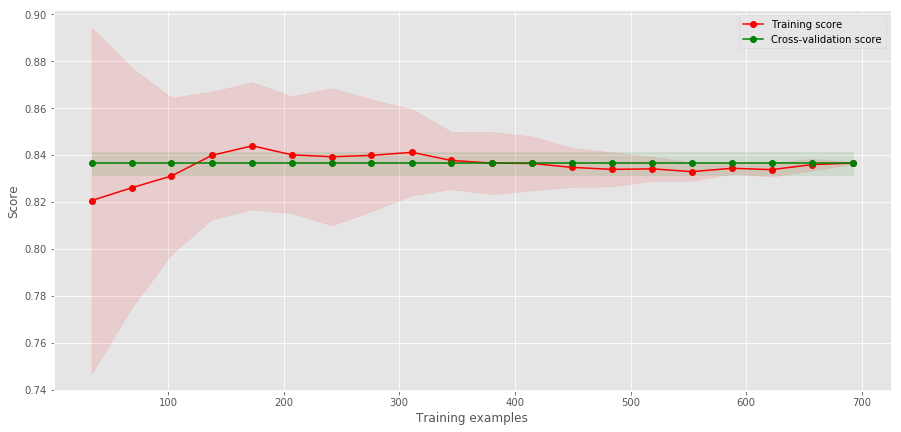

In [125]:
parameters = {'min_samples_split':[40, 50, 60], 'min_samples_leaf':range(10,60,10)}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'min_samples_leaf': 10, 'min_samples_split': 10}
训练集得分: 0.8364
测试集得分: 0.8424


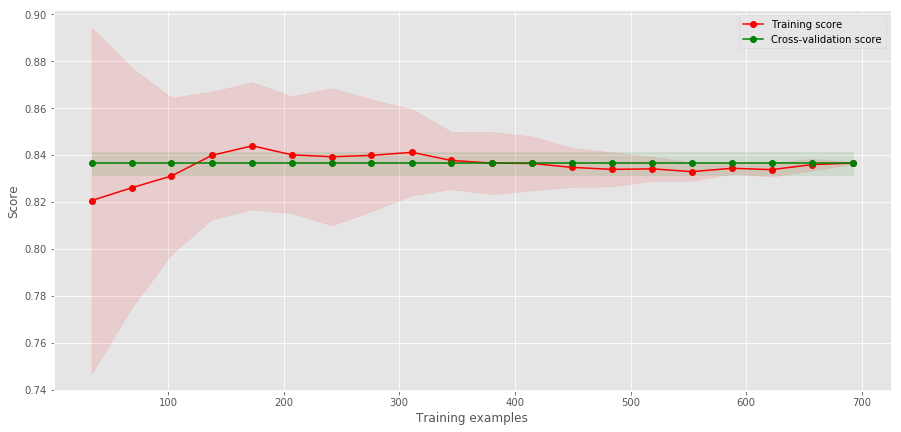

In [126]:
parameters = {'min_samples_split':[10, 5], 'min_samples_leaf':range(10,60,10)}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8364
最佳分类器参数为: {'max_features': 'sqrt'}
训练集得分: 0.8364
测试集得分: 0.8424


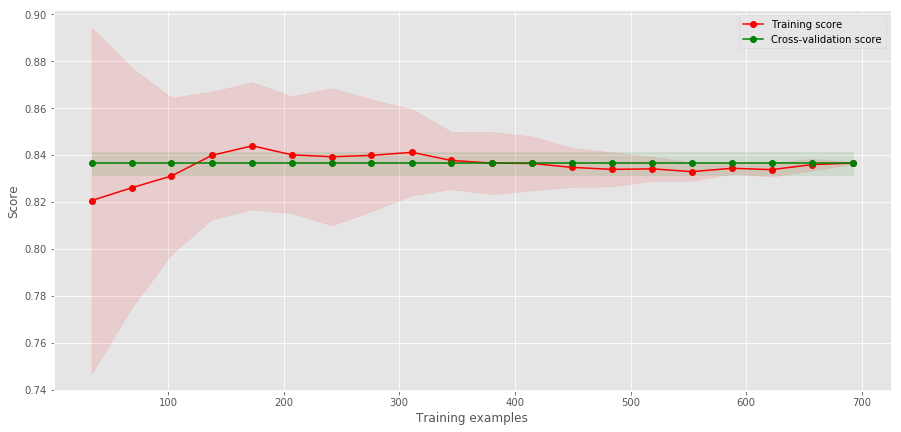

In [127]:
# 确定最大深度max_depth和min_samples_split
parameters = {'max_features':['sqrt', 'log2']}

rf, _ = gridsearch(rf, parameters, kfold, X_train, y_train, X_test, y_test)

####  AdaBooster调参

交叉验证报告
最佳得分： 0.8766
最佳分类器参数为: {'learning_rate': 0.60000000000000009, 'n_estimators': 60}
训练集得分: 0.8987
测试集得分: 0.8636


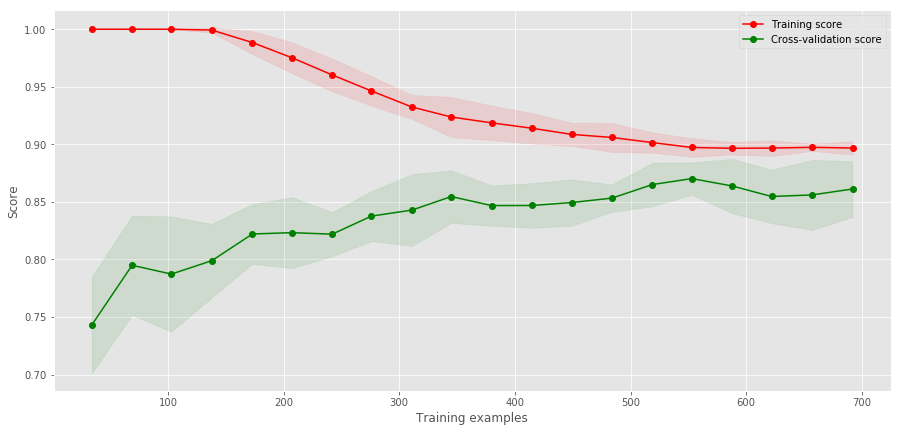

In [155]:
adaboost = AdaBoostClassifier(random_state=45)
parameters = {'n_estimators':range(40, 101, 20), 'learning_rate': np.linspace(0.2, 1, 9)}

adaboost, _ = gridsearch(adaboost, parameters, kfold, X_train, y_train, X_test, y_test)

####  GBDT调参

交叉验证报告
最佳得分： 0.8597
最佳分类器参数为: {'n_estimators': 70}
训练集得分: 0.8831
测试集得分: 0.8758


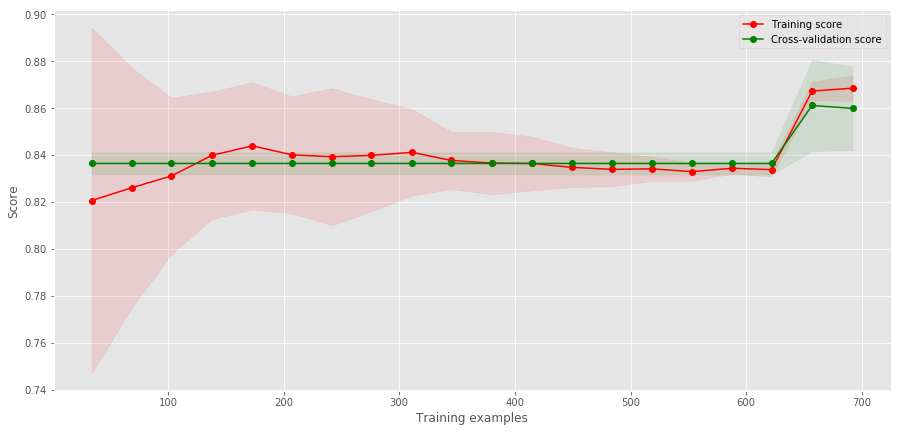

In [133]:
gbdt = GradientBoostingClassifier(learning_rate=0.1,
                           min_samples_split=500,
                           min_samples_leaf=50,
                           max_depth=8,
                           max_features='sqrt',
                           subsample=0.8,
                           random_state=45)
parameters = {'n_estimators':range(20,81,10)}

gbdt, _ = gridsearch(gbdt, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8636
最佳分类器参数为: {'max_depth': 5, 'min_samples_split': 200}
训练集得分: 0.8714
测试集得分: 0.8636


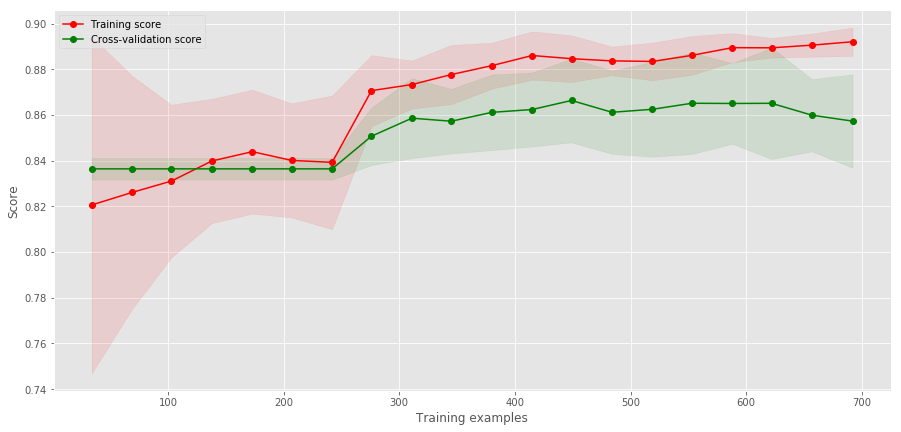

In [135]:
parameters =  {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gbdt, _ = gridsearch(gbdt, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8701
最佳分类器参数为: {'max_depth': 6, 'min_samples_split': 100}
训练集得分: 0.8935
测试集得分: 0.8758


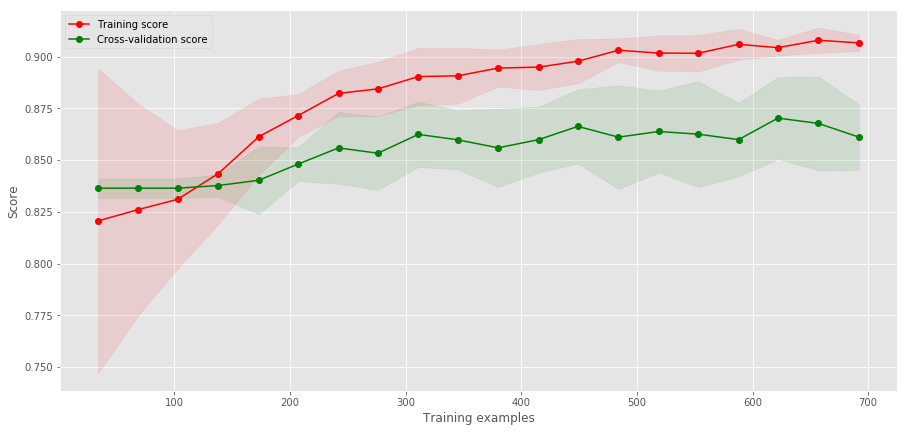

In [137]:
parameters =  {'max_depth':[4, 5, 6], 'min_samples_split':[100, 200, 300]}
gbdt, _ = gridsearch(gbdt, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8701
最佳分类器参数为: {'max_depth': 6, 'min_samples_split': 50}
训练集得分: 0.9065
测试集得分: 0.8879


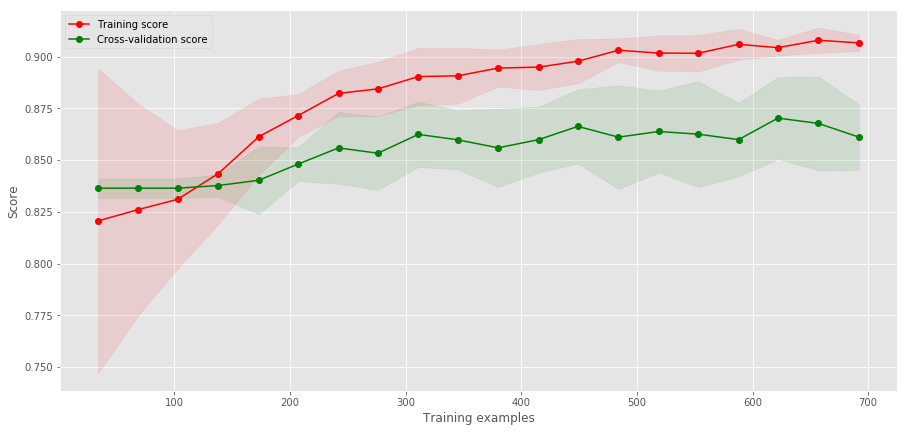

In [139]:
parameters =  {'max_depth':[4, 5, 6], 'min_samples_split':range(50, 101, 10)}
gbdt, _ = gridsearch(gbdt, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8701
最佳分类器参数为: {'max_depth': 6, 'min_samples_split': 2}
训练集得分: 0.9052
测试集得分: 0.8848


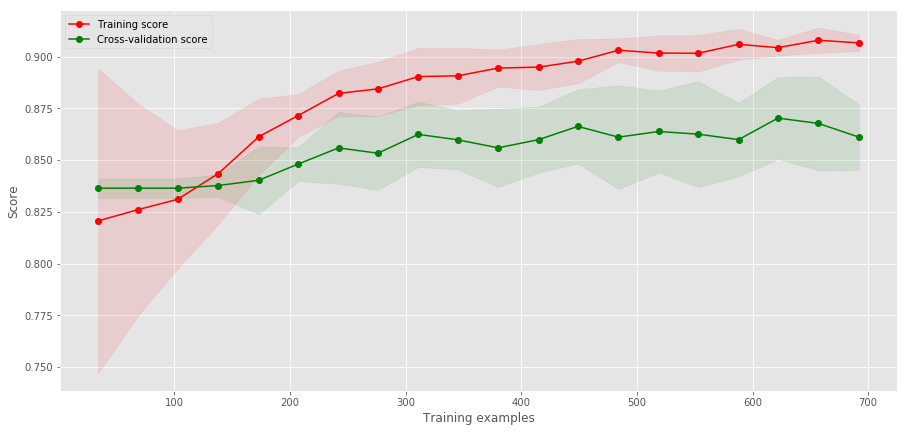

In [142]:
parameters =  {'max_depth':[4, 5, 6], 'min_samples_split':range(2, 11)}
gbdt, _ = gridsearch(gbdt, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8675
最佳分类器参数为: {'min_samples_leaf': 30, 'min_samples_split': 2}
训练集得分: 0.9052
测试集得分: 0.8848


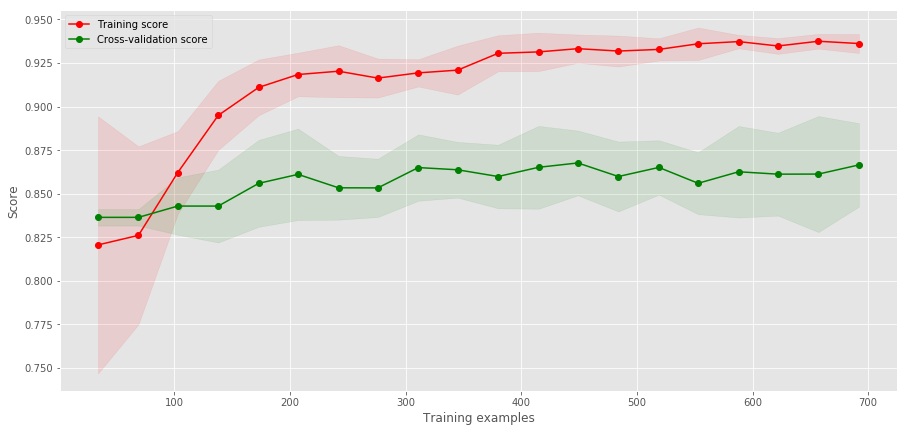

In [143]:
parameters =  {'min_samples_leaf':range(10, 31,10), 'min_samples_split':range(2, 11)}
gbdt, _ = gridsearch(gbdt, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8675
最佳分类器参数为: {'min_samples_leaf': 30, 'min_samples_split': 2}
训练集得分: 0.9312
测试集得分: 0.8758


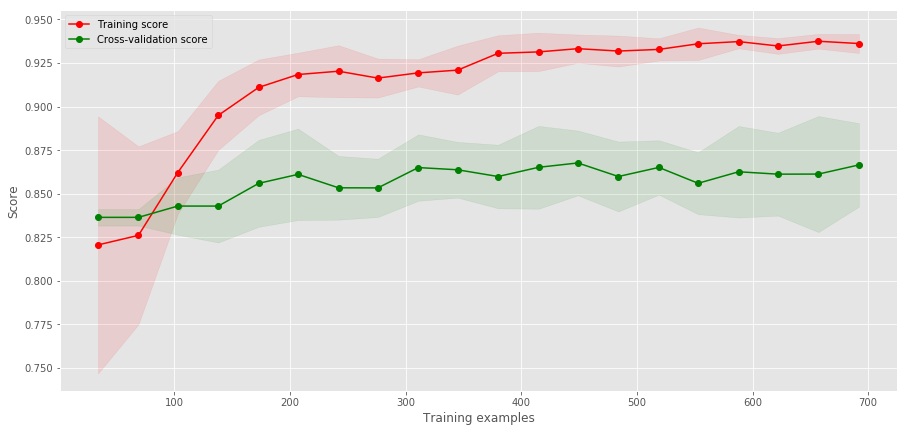

In [144]:
parameters =  {'min_samples_leaf':[30, 40], 'min_samples_split':range(2, 11)}
gbdt, _ = gridsearch(gbdt, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8844
最佳分类器参数为: {'max_features': 9}
训练集得分: 0.9312
测试集得分: 0.8758


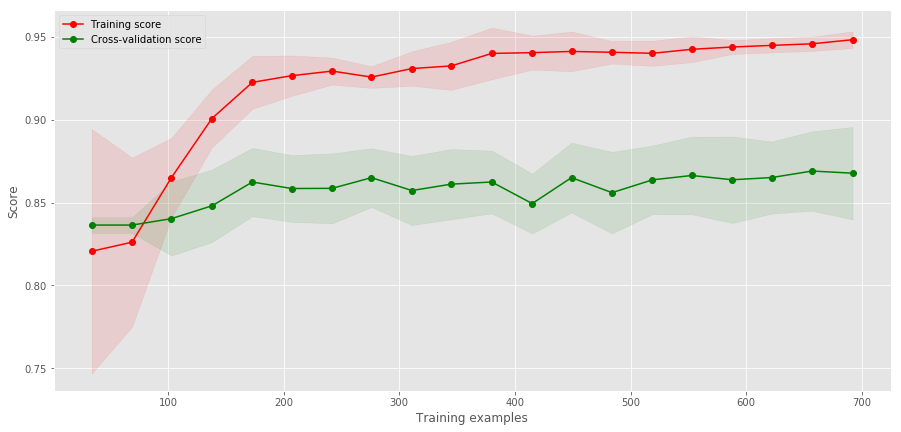

In [145]:
parameters =  {'max_features':range(5, 17)}
gbdt, _ = gridsearch(gbdt, parameters, kfold, X_train, y_train, X_test, y_test)

交叉验证报告
最佳得分： 0.8844
最佳分类器参数为: {'subsample': 0.8}
训练集得分: 0.9416
测试集得分: 0.8788


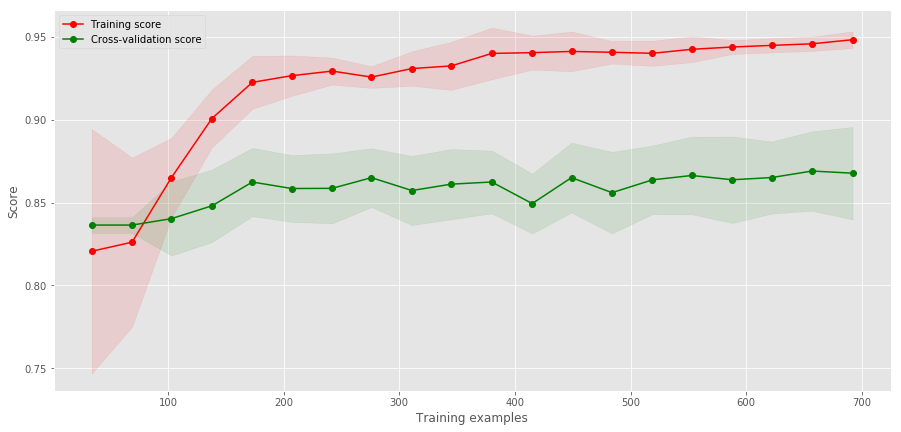

In [146]:
parameters =  {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gbdt, _ = gridsearch(gbdt, parameters, kfold, X_train, y_train, X_test, y_test)

In [147]:
base_gbdt = gbdt
base_gbdt.fit(X_train, y_train)
score = base_gbdt.score(X_test, y_test)
score

0.87878787878787878

In [148]:
base_gbdt1 = gbdt
base_gbdt1.set_params(**({'learning_rate':0.05, 'n_estimators':140}))
base_gbdt1.fit(X_train, y_train)
score = base_gbdt1.score(X_test, y_test)
score

0.87575757575757573

In [149]:
base_gbdt2 = gbdt
base_gbdt2.set_params(**({'learning_rate':0.01, 'n_estimators':700}))
base_gbdt2.fit(X_train, y_train)
score = base_gbdt2.score(X_test, y_test)
score

0.87575757575757573

In [151]:
base_gbdt3 = gbdt
base_gbdt3.set_params(**({'learning_rate':0.1, 'n_estimators':70}))
base_gbdt3.fit(X_train, y_train)
score = base_gbdt3.score(X_test, y_test)
score

0.87878787878787878

In [96]:
base_gbdt4 = gbdt
base_gbdt4.set_params(**({'learning_rate':0.05, 'n_estimators':140}))
base_gbdt4.fit(X_train, y_train)
score = base_gbdt4.score(X_test, y_test)
score

0.87575757575757573

#### 优化模型汇总

In [156]:
model = []
model.append(('LogisticRegression', lr))
model.append(('RandomForestClassifier', rf))
model.append(('AdaBoostClassifier', adaboost))
model.append(('GradientBoostingClassifier', base_gbdt3))

In [157]:
result_df = pd.DataFrame(np.zeros((4,4)), columns=['分类器', '交叉验证得分', '验证集得分', '耗时'])

In [158]:
for i, (name, clf) in enumerate(model):
    start = time.time()
    cv = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=kfold)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    result_df.iloc[i, 0] = name
    result_df.iloc[i, 1] = '{0:.4f}(+/-{0:.4f})'.format(cv.mean(), cv.std())
    result_df.iloc[i, 2] = '{0:.4f}'.format(score)
    result_df.iloc[i, 3] = '{0:.4f}'.format(time.time() - start)
    
result_df

,分类器,交叉验证得分,验证集得分,耗时
0,LogisticRegression,0.8794(+/-0.8794),0.8909,0.1181
1,RandomForestClassifier,0.8364(+/-0.8364),0.8424,0.0931
2,AdaBoostClassifier,0.8767(+/-0.8767),0.8788,2.0609
3,GradientBoostingClassifier,0.8846(+/-0.8846),0.8788,1.4550


In [159]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(model, voting='soft')
cv = cross_val_score(estimator=ensemble, X=X_train, y=y_train, cv=kfold)
ensemble.fit(X_train, y_train)
score = ensemble.score(X_test, y_test)
'{:.4f}'.format(score)

'0.8667'

In [160]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def get_oof(self, feature_train, label_train, feature_test):
        '''
        有base_model对训练集和测试集进行预测，生成第二层分类器所需的数据集
        feature_train: 训练集
        label_train: 训练集标签
        feature_test: 测试集
        '''

        # 生成用于存放第一层分类器预测结果的DataFrame
        # 训练集样本数 × base_model数目
        S_train = pd.DataFrame(
            np.zeros((feature_train.shape[0], len(self.base_models))),
            columns=self.base_models.keys())

        # 生成用于存放测试集预测结果的DataFrame
        # 测试集样本数 × base_model数目
        S_test = pd.DataFrame(
            np.zeros((feature_test.shape[0], len(self.base_models))),
            columns=self.base_models.keys())

        folds = StratifiedKFold(
            n_splits=self.n_splits, shuffle=True, random_state=45).split(
                feature_train, label_train)

        # 对每一个base_model进行训练和预测
        for name, clf in self.base_models.items():

            S_test_i = np.zeros((feature_test.shape[0], self.n_splits))

            # 对训练集进行K折交叉
            for j, (train_idx, test_idx) in enumerate(folds):
                # 生成交叉后的训练集
                kf_X_train = feature_train[train_idx]
                # 生成交叉后的训练样本对应的标签
                kf_y_train = label_train[train_idx]

                # 生成交叉后的验证集
                kf_X_test = feature_train[test_idx]

                #拟合训练集，生成模型
                clf.fit(kf_X_train, kf_y_train)

                y_pred = clf.predict(kf_X_test)

                S_train.loc[test_idx, name] = y_pred
                S_test_i[:, j] = clf.predict(feature_test)

            S_test.loc[:, name] = S_test_i.mean(axis=1)

        return S_train, S_test

In [162]:
base_models = {}
for name, clf in model:
    base_models.setdefault(name, clf)

In [163]:
stack = Ensemble(5, stacker=lr, base_models=base_models)
train_df, test_df = stack.get_oof(X_train.values,y_train.ravel(), X_test.values)

In [167]:
cv = cross_val_score(estimator=gbm, X=train_df, y=y_train, cv=kfold)
gbm.fit(train_df, y_train)
score = gbm.score(test_df, y_test)
'{:.4f}'.format(score)

'0.8909'

#### XGBOOST调参

In [165]:
def modelfit(alg, X, y, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,metrics='auc',seed=45,
                          early_stopping_rounds=early_stopping_rounds)
        if alg.get_params()['n_estimators'] > cvresult.shape[0]:
            print('Stopping. Best interation [{}]'.format(cvresult.shape[0]))
        alg.set_params(n_estimators=cvresult.shape[0])
        
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='auc')
    
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Predict testing set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy (Train): %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("Accuracy (Test): %.4g" % metrics.accuracy_score(y_test.values, dtest_predictions))
    print("AUC Score (Train): %.4f" % metrics.roc_auc_score(y, dtrain_predprob))
    print("AUC Score (Test): %.4f" % metrics.roc_auc_score(y_test, dtest_predprob))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    fig = plt.figure(figsize=(15,5))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Stopping. Best interation [211]

Model Report
Accuracy (Train): 1
Accuracy (Test): 0.8727
AUC Score (Train): 1.0000
AUC Score (Test): 0.7774


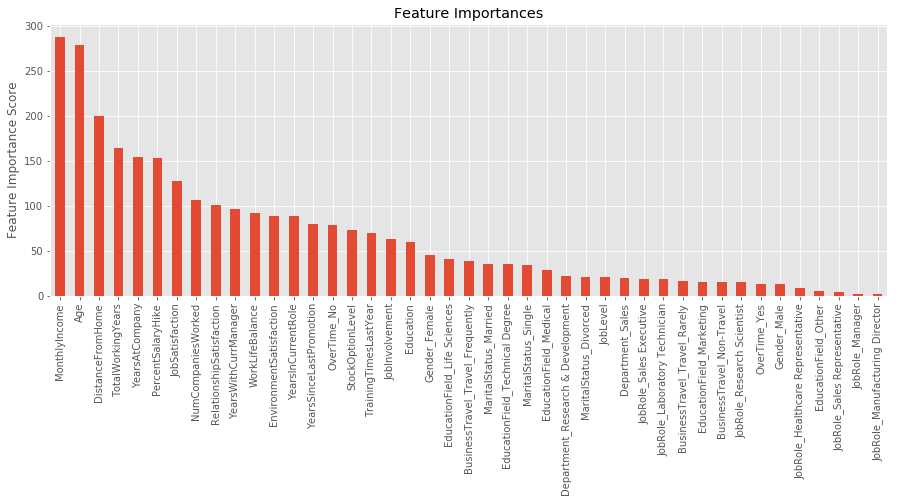

In [166]:
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
gbm = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=45)
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

交叉验证报告
最佳得分： 0.8714
最佳分类器参数为: {'max_depth': 3, 'min_child_weight': 3}
训练集得分: 1.0000
测试集得分: 0.8727

Model Report
Accuracy (Train): 0.9805
Accuracy (Test): 0.8667
AUC Score (Train): 0.9985
AUC Score (Test): 0.8016


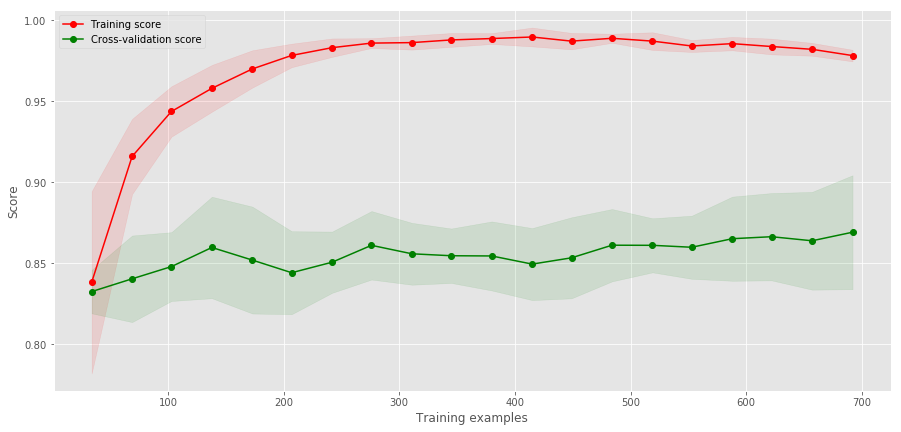

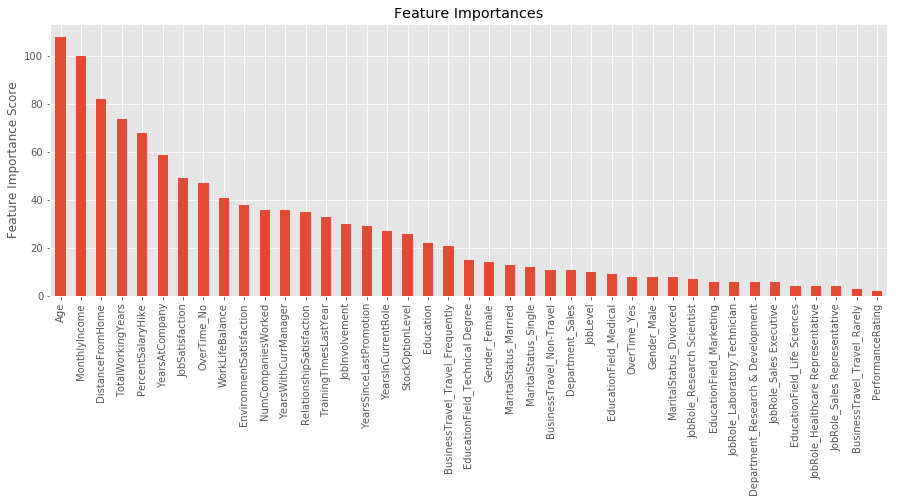

In [168]:
parameters =  {'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}
gbm, _ = gridsearch(gbm, parameters, kfold, X_train, y_train, X_test, y_test)
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

交叉验证报告
最佳得分： 0.8727
最佳分类器参数为: {'max_depth': 3, 'min_child_weight': 2}
训练集得分: 0.9805
测试集得分: 0.8667

Model Report
Accuracy (Train): 0.9857
Accuracy (Test): 0.8758
AUC Score (Train): 0.9995
AUC Score (Test): 0.7827


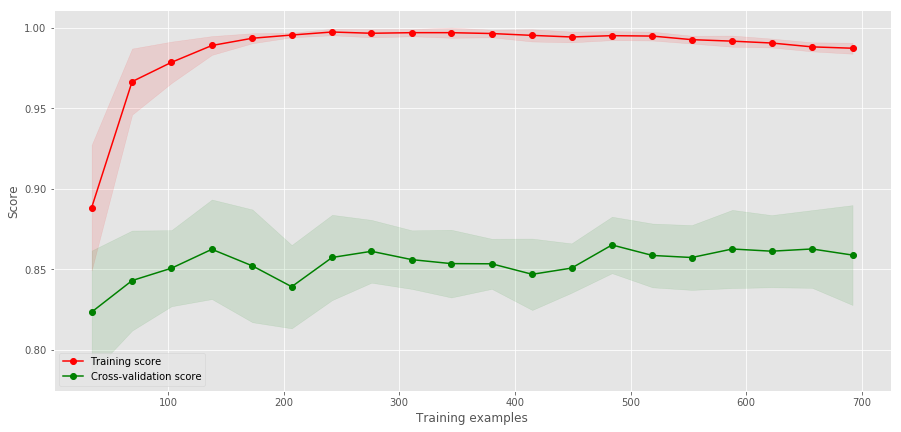

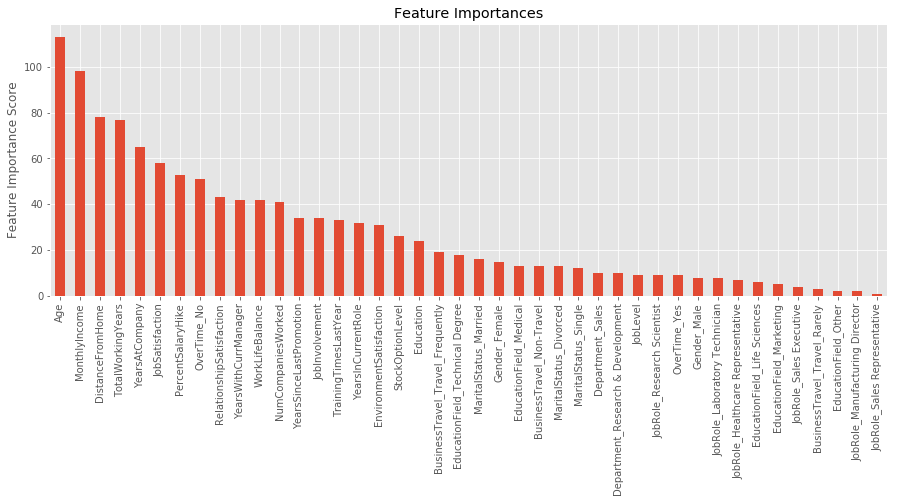

In [169]:
parameters =  {'max_depth':[2, 3, 4],'min_child_weight':[2, 3, 4]}
gbm, _ = gridsearch(gbm, parameters, kfold, X_train, y_train, X_test, y_test)
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

交叉验证报告
最佳得分： 0.8727
最佳分类器参数为: {'max_depth': 3, 'min_child_weight': 2}
训练集得分: 0.9857
测试集得分: 0.8758

Model Report
Accuracy (Train): 0.9857
Accuracy (Test): 0.8758
AUC Score (Train): 0.9995
AUC Score (Test): 0.7827


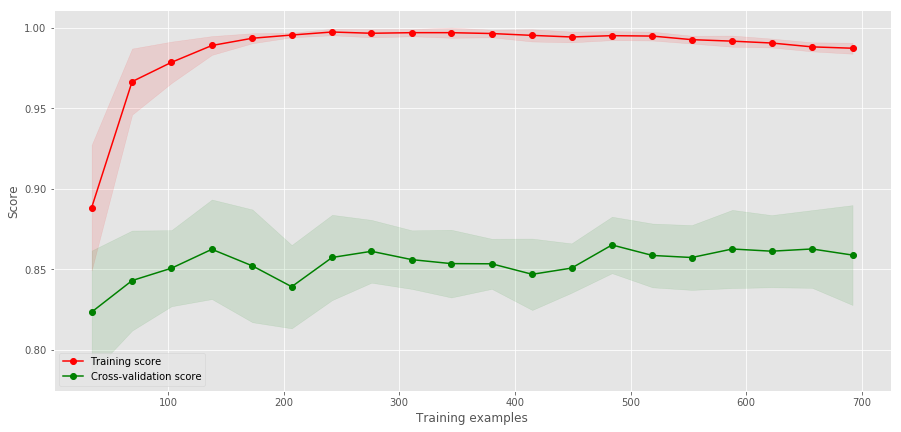

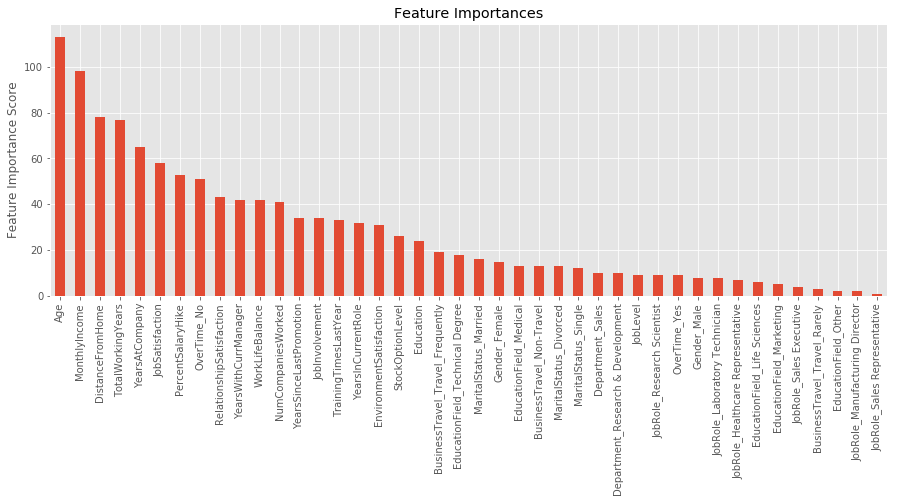

In [170]:
parameters =  {'max_depth':[2, 3, 4],'min_child_weight':[1, 2]}
gbm, _ = gridsearch(gbm, parameters, kfold, X_train, y_train, X_test, y_test)
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

交叉验证报告
最佳得分： 0.8727
最佳分类器参数为: {'gamma': 0.0}
训练集得分: 0.9857
测试集得分: 0.8758

Model Report
Accuracy (Train): 0.9857
Accuracy (Test): 0.8758
AUC Score (Train): 0.9995
AUC Score (Test): 0.7827


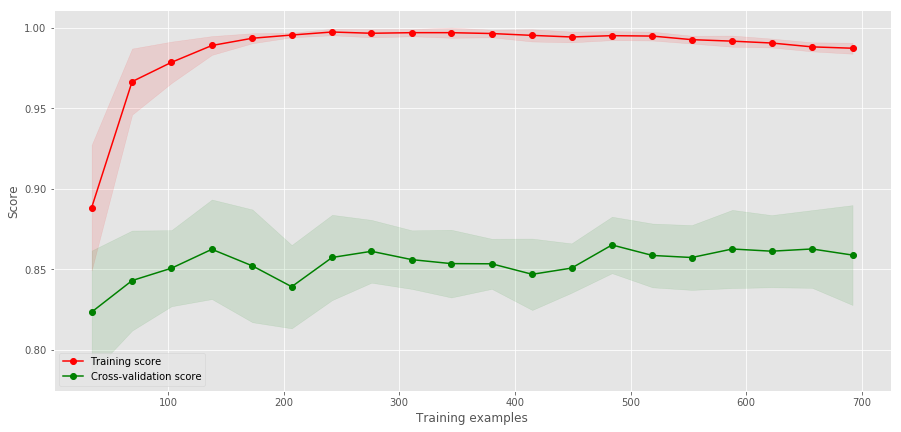

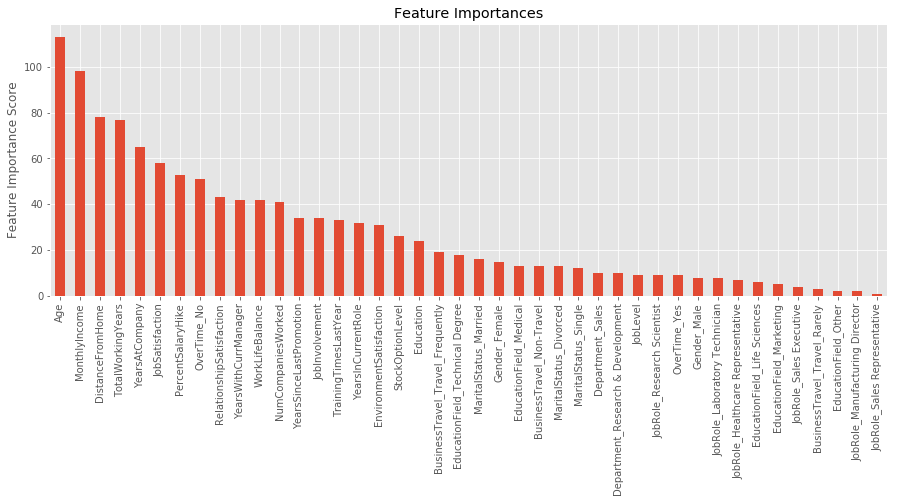

In [172]:
parameters =  {'gamma':[i/10.0 for i in range(0,5)]}
gbm, _ = gridsearch(gbm, parameters, kfold, X_train, y_train, X_test, y_test)
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

Stopping. Best interation [178]

Model Report
Accuracy (Train): 0.9727
Accuracy (Test): 0.8727
AUC Score (Train): 0.9985
AUC Score (Test): 0.7817


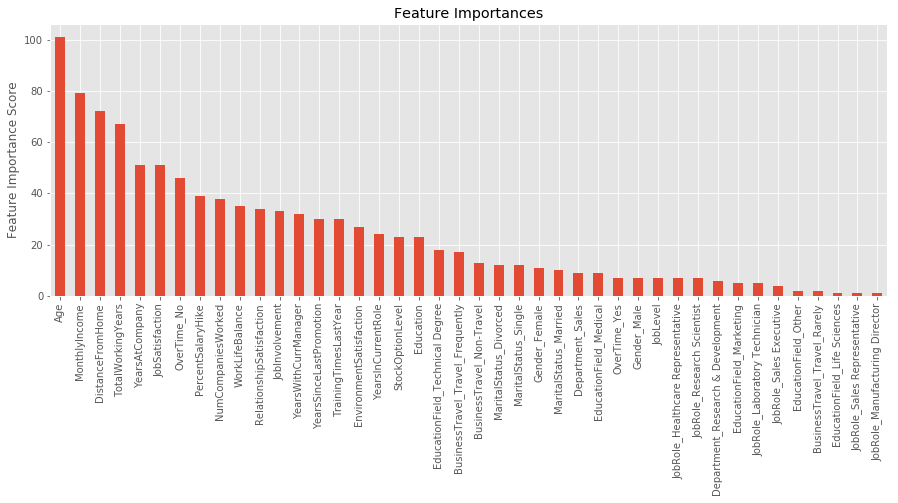

In [173]:
gbm.set_params(**({'n_estimators':1000}))
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

交叉验证报告
最佳得分： 0.8753
最佳分类器参数为: {'colsample_bytree': 0.6, 'subsample': 0.6}
训练集得分: 0.9727
测试集得分: 0.8727

Model Report
Accuracy (Train): 0.9636
Accuracy (Test): 0.8727
AUC Score (Train): 0.9965
AUC Score (Test): 0.8015


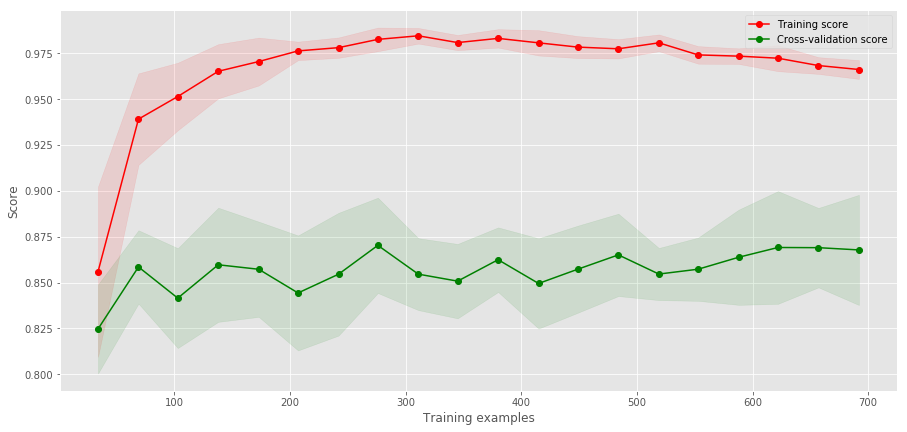

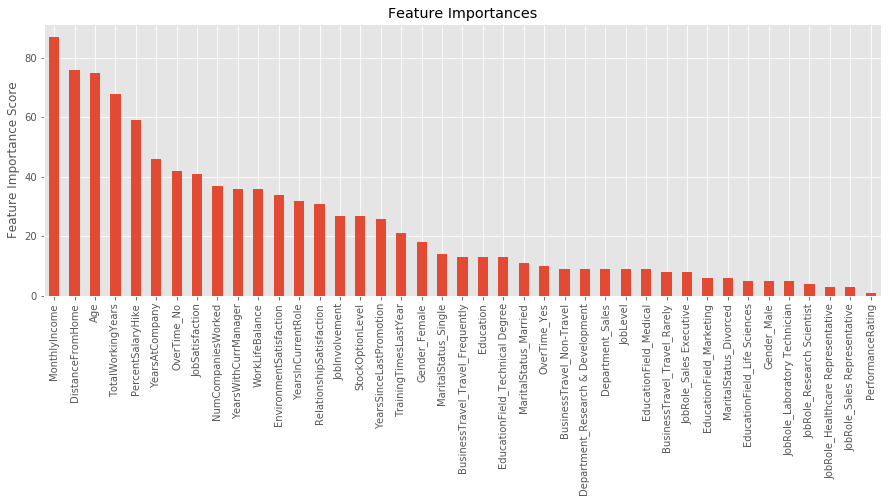

In [174]:
parameters =   {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gbm, _ = gridsearch(gbm, parameters, kfold, X_train, y_train, X_test, y_test)
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

交叉验证报告
最佳得分： 0.8779
最佳分类器参数为: {'colsample_bytree': 0.4, 'subsample': 0.6}
训练集得分: 1.0000
测试集得分: 0.8545
Stopping. Best interation [180]

Model Report
Accuracy (Train): 0.9584
Accuracy (Test): 0.8788
AUC Score (Train): 0.9952
AUC Score (Test): 0.7998


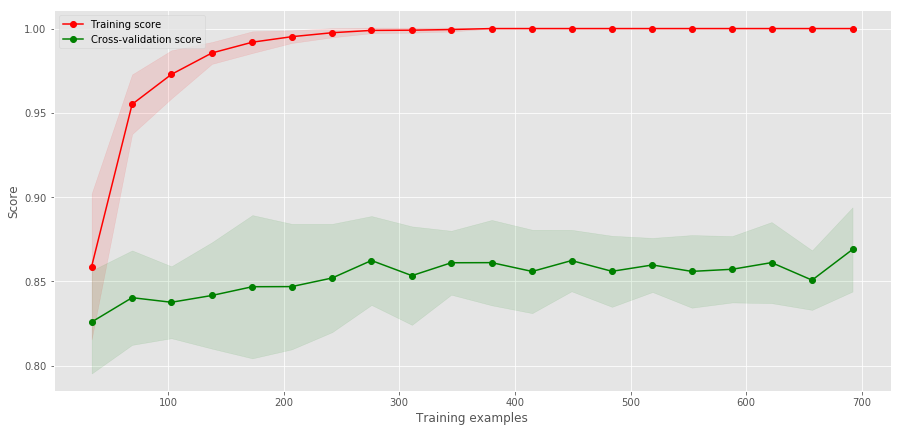

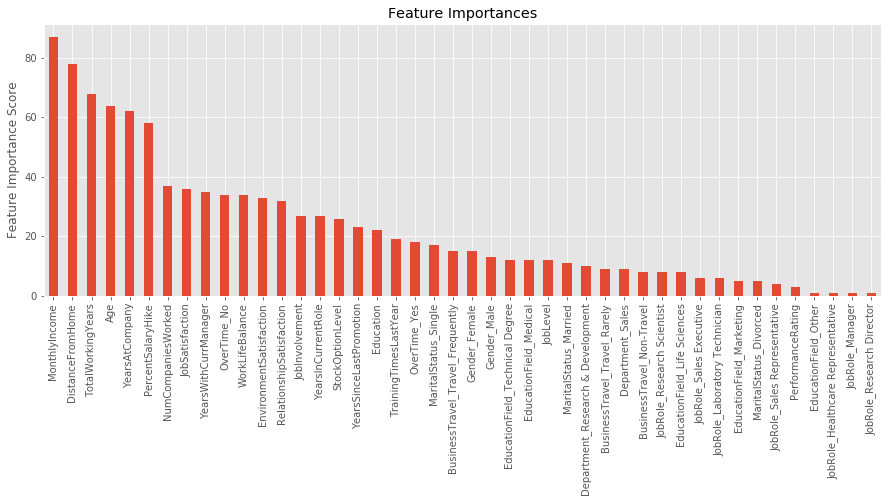

In [176]:
parameters =   {
 'subsample':[i/10.0 for i in range(1, 7)],
 'colsample_bytree':[i/10.0 for i in range(1, 7)]
}
gbm, _ = gridsearch(gbm, parameters, kfold, X_train, y_train, X_test, y_test)
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

最佳分类器参数为:{'reg_alpha': 1e-05}
最好得分:0.8779
Stopping. Best interation [180]

Model Report
Accuracy (Train): 0.9584
Accuracy (Test): 0.8788
AUC Score (Train): 0.9952
AUC Score (Test): 0.7998


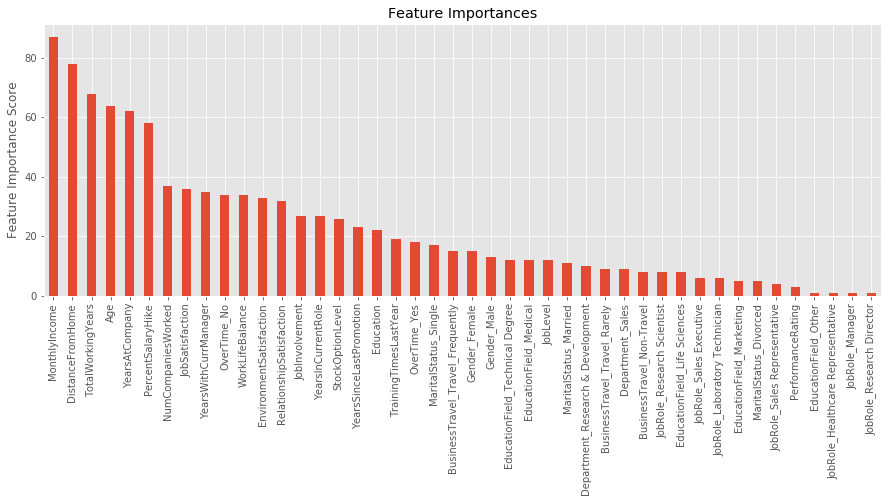

In [177]:
parameters =    {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gbm.set_params(**({'n_estimators':1000}))
grid_obj = GridSearchCV(estimator=gbm, param_grid=parameters, cv=kfold).fit(X_train, y_train)
gbm = grid_obj.best_estimator_
print('最佳分类器参数为:{}'.format(grid_obj.best_params_))
print('最好得分:{0:.4f}'.format(grid_obj.best_score_))
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

最佳分类器参数为:{'reg_alpha': 0.001}
最好得分:0.8779

Model Report
Accuracy (Train): 0.9584
Accuracy (Test): 0.8818
AUC Score (Train): 0.9952
AUC Score (Test): 0.8013


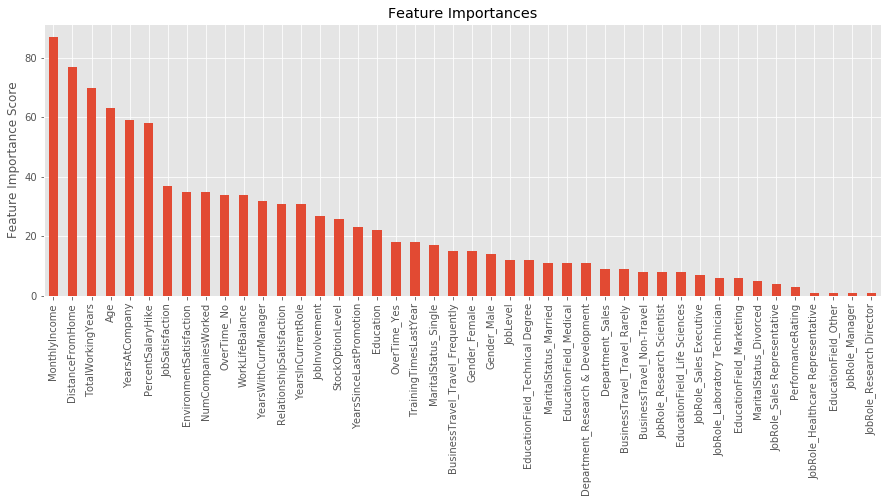

In [178]:
parameters =    {
 'reg_alpha':[1e-5, 1e-4, 1e-3]
}
grid_obj = GridSearchCV(estimator=gbm, param_grid=parameters, cv=kfold).fit(X_train, y_train)
gbm = grid_obj.best_estimator_
print('最佳分类器参数为:{}'.format(grid_obj.best_params_))
print('最好得分:{0:.4f}'.format(grid_obj.best_score_))
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

最佳分类器参数为:{'reg_alpha': 0.001}
最好得分:0.8779

Model Report
Accuracy (Train): 0.9584
Accuracy (Test): 0.8818
AUC Score (Train): 0.9952
AUC Score (Test): 0.8013


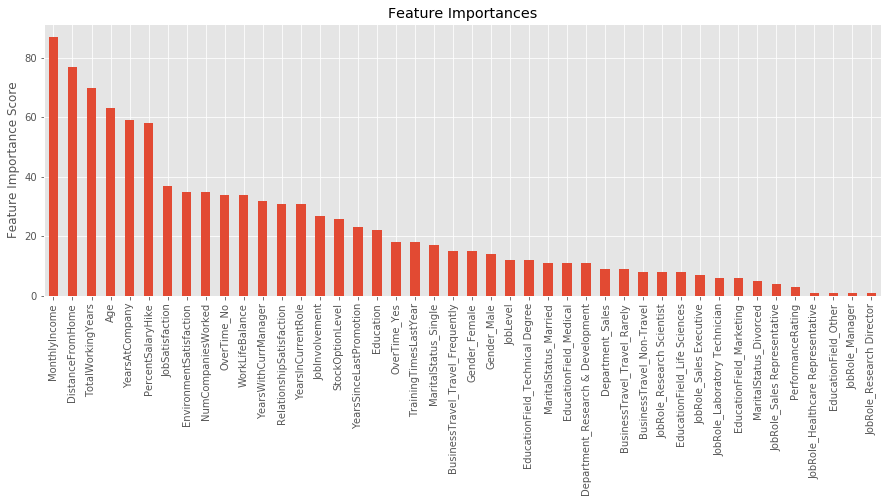

In [179]:
parameters =    {
 'reg_alpha':[0.005, 0.0005, 0.001]
}
grid_obj = GridSearchCV(estimator=gbm, param_grid=parameters, cv=kfold).fit(X_train, y_train)
gbm = grid_obj.best_estimator_
print('最佳分类器参数为:{}'.format(grid_obj.best_params_))
print('最好得分:{0:.4f}'.format(grid_obj.best_score_))
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

Stopping. Best interation [331]

Model Report
Accuracy (Train): 0.9896
Accuracy (Test): 0.8636
AUC Score (Train): 0.9999
AUC Score (Test): 0.7905


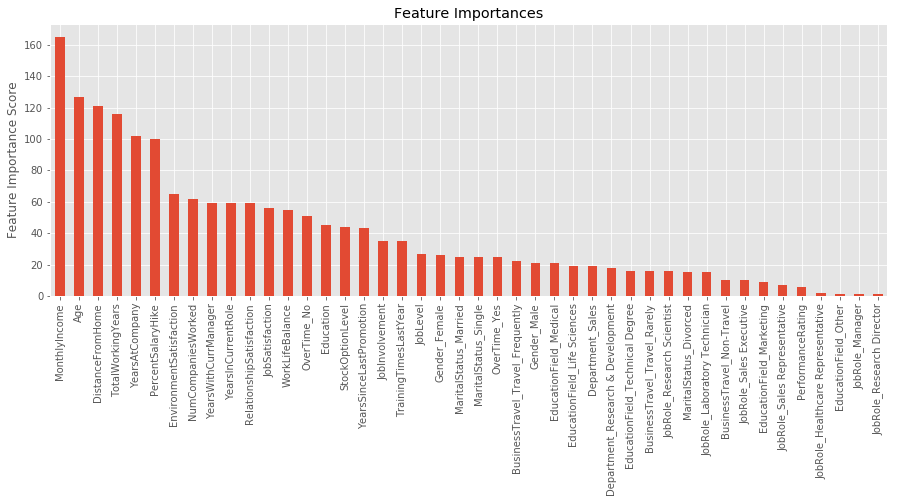

In [184]:
gbm.set_params(**({'learning_rate':0.1, 'n_estimators':2000}))
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10, early_stopping_rounds=50)

Stopping. Best interation [326]

Model Report
Accuracy (Train): 0.9506
Accuracy (Test): 0.8879
AUC Score (Train): 0.9932
AUC Score (Test): 0.8031


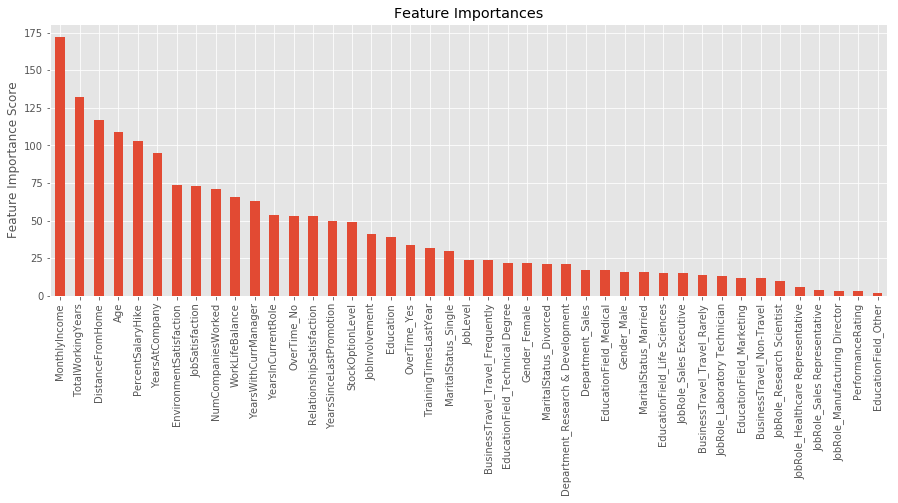

In [185]:
gbm.set_params(**({'learning_rate':0.05, 'n_estimators':2000}))
modelfit(gbm, X_train, y_train,X_test, y_test, useTrainCV=True, cv_folds=10)

In [186]:
cv = cross_val_score(estimator=gbm, X=X_train, y=y_train, cv=kfold)
gbm.fit(X_train, y_train)
score = gbm.score(X_test, y_test)
'{:.4f}'.format(score)

'0.8879'

In [187]:
lr.fit(X_train, y_train)
result_lr = lr.predict(X_test)
result_gbm = gbm.predict(X_test)
result = pd.DataFrame({'lr': result_lr, 'gbm':result_gbm, 'true':y_test})
result.to_csv('comp.csv', index=False)

In [192]:
error_bool = (result_lr != y_test)

In [208]:
temp_df = X_test
temp_df['Attrition'] = y_test
temp_df['pred'] = result_lr
lr_error = temp_df[error_bool]
lr_error.to_csv('lr_error.csv')

In [209]:
import seaborn as sns


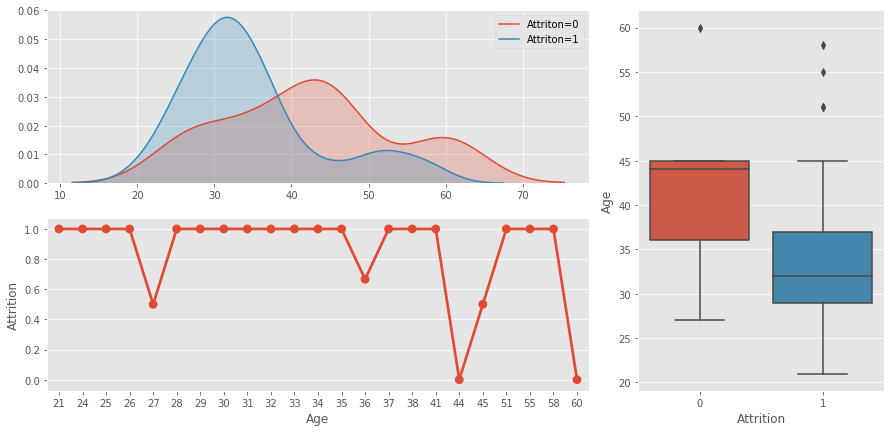

In [211]:
fig = plt.figure(figsize=(15,7))

plt.subplot2grid((2,3),(0,0), colspan=2)
facet = sns.kdeplot(lr_error[lr_error['Attrition']==0]['Age'], shade=True, label='Attriton=0')
facet = sns.kdeplot(lr_error[lr_error['Attrition']==1]['Age'], shade=True, label='Attriton=1')
facet.set(ylim=(0, .06))
#facet.add_legend()

plt.subplot2grid((2,3),(1,0), colspan=2)
#sns.barplot(x='Age', y='Attrition', data=df_train)
sns.pointplot(x='Age', y='Attrition', data=lr_error, errwidth=0)

plt.subplot2grid((2,3),(0,2), rowspan=2)
sns.boxplot(x='Attrition', y='Age', data=lr_error)

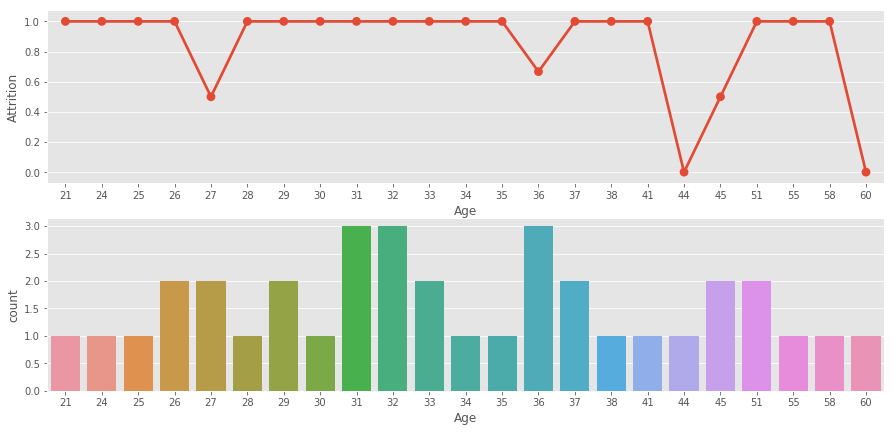

In [212]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,7))
#sns.barplot(x='Age', y='Attrition', data=df_train, ax=ax1)
sns.countplot(x='Age', data=lr_error, ax=ax2)
sns.pointplot(x='Age', y='Attrition', data=lr_error, errwidth=0, ax=ax1)

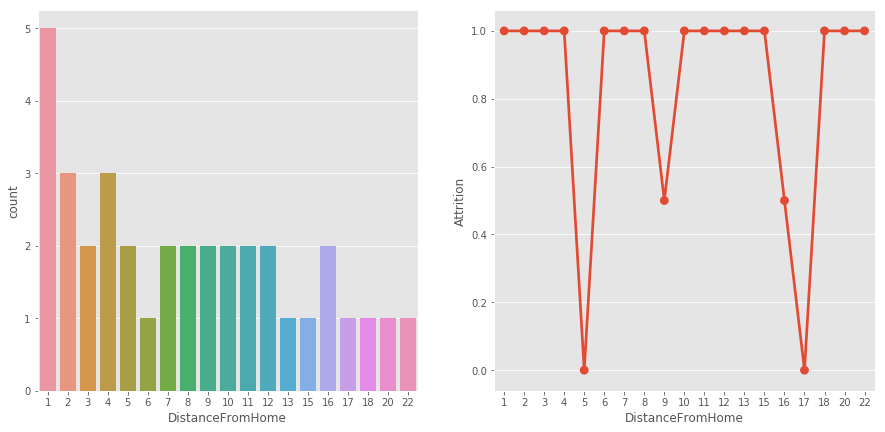

In [213]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
sns.countplot(x='DistanceFromHome', data=lr_error, ax=ax1)
sns.pointplot(x='DistanceFromHome', y='Attrition', data=lr_error, ax=ax2, errwidth=0)

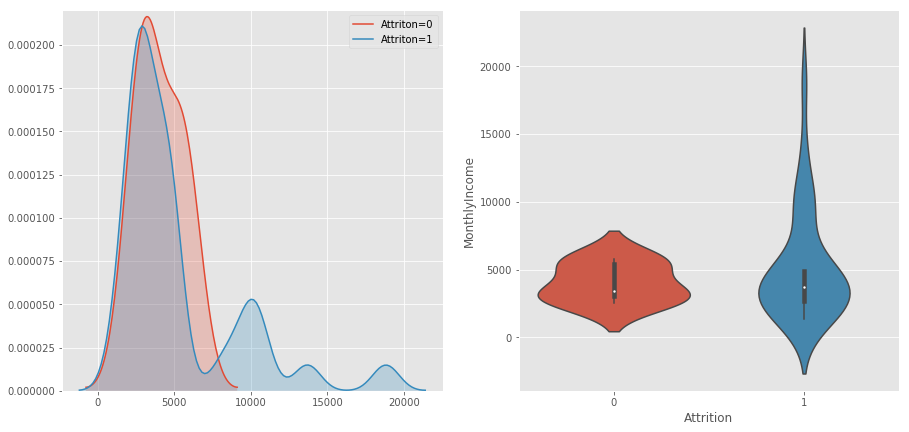

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

facet = sns.kdeplot(lr_error[lr_error['Attrition']==0]['MonthlyIncome'],
                    shade=True, label='Attriton=0', ax=ax1)
facet = sns.kdeplot(lr_error[lr_error['Attrition']==1]['MonthlyIncome'],
                    shade=True, label='Attriton=1', ax=ax1)
facet.set(ylim=(0, .00022))

sns.violinplot(x='Attrition', y='MonthlyIncome', data=lr_error, ax=ax2)